Modelling with Mutual Information n = 25

In [1]:
# Base Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import time
from collections import defaultdict

# Data Analysis Libraries
from sklearn.base import clone
from sklearn.feature_selection import VarianceThreshold, SelectFromModel, RFE, SelectKBest, mutual_info_classif
from sklearn.preprocessing import MinMaxScaler,StandardScaler, RobustScaler, MaxAbsScaler, LabelEncoder, OneHotEncoder, PowerTransformer
from sklearn.metrics import mean_squared_error,accuracy_score,recall_score,precision_score,f1_score,roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split, RepeatedKFold, KFold, cross_val_score, GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier
import xgboost as xgb
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier

In [2]:
csv_file = 'CICDDoS-Real/cicddos2019_cleaned.csv'
df = pd.read_csv(csv_file, low_memory=False)
df.shape

(360000, 88)

In [3]:
# Mengacak seluruh baris DataFrame
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

### Informasi Dataset

In [4]:
#info dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360000 entries, 0 to 359999
Data columns (total 88 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   360000 non-null  int64  
 1   Flow ID                      360000 non-null  object 
 2   Source IP                    360000 non-null  object 
 3   Source Port                  360000 non-null  int64  
 4   Destination IP               360000 non-null  object 
 5   Destination Port             360000 non-null  int64  
 6   Protocol                     360000 non-null  int64  
 7   Timestamp                    360000 non-null  object 
 8   Flow Duration                360000 non-null  int64  
 9   Total Fwd Packets            360000 non-null  int64  
 10  Total Backward Packets       360000 non-null  int64  
 11  Total Length of Fwd Packets  360000 non-null  float64
 12  Total Length of Bwd Packets  360000 non-null  float64
 13 

In [5]:
#Bagian awal dataset
df.head()

Unnamed: 0                                 Flow ID   Source IP  \
0       28102    172.16.0.5-192.168.50.1-553-11930-17  172.16.0.5   
1       17675     172.16.0.5-192.168.50.1-997-4051-17  172.16.0.5   
2      661545    172.16.0.5-192.168.50.1-27238-3411-6  172.16.0.5   
3      688385   172.16.0.5-192.168.50.1-36181-39435-6  172.16.0.5   
4       16016  172.16.0.5-192.168.50.1-35261-14404-17  172.16.0.5   

   Source Port Destination IP  Destination Port  Protocol  \
0          553   192.168.50.1             11930        17   
1          997   192.168.50.1              4051        17   
2        27238   192.168.50.1              3411         6   
3        36181   192.168.50.1             39435         6   
4        35261   192.168.50.1             14404        17   

                    Timestamp  Flow Duration  Total Fwd Packets  ...  \
0  2018-12-01 11:23:04.133911              1                  2  ...   
1  2018-12-01 11:32:18.205323              2                  2  ...   
2  2018-12-01 13:31:10.155752              1                  2  ...   
3  2018-12-01 13:30:48.279274             51                  2  ...   
4  2018-12-01 13:02:49.155721         105961                  4  ...   

   Active Std  Active Max  Active Min  Idle Mean  Idle Std  Idle Max  \
0         0.0         0.0         0.0        0.0       0.0       0.0   
1         0.0         0.0         0.0        0.0       0.0       0.0   
2         0.0         0.0         0.0        0.0       0.0       0.0   
3         0.0         0.0         0.0        0.0       0.0       0.0   
4         0.0         0.0         0.0        0.0       0.0       0.0   

   Idle Min  SimillarHTTP  Inbound       Label  
0       0.0             0        1  DrDoS_LDAP  
1       0.0             0        1  DrDoS_LDAP  
2       0.0             0        1         Syn  
3       0.0             0        1         Syn  
4       0.0             0        1   DrDoS_UDP  

[5 rows x 88 columns]

In [6]:
df.describe()

Unnamed: 0    Source Port  Destination Port       Protocol  \
count  360000.000000  360000.000000     360000.000000  360000.000000   
mean    91493.758128   26078.477756      30912.601833      14.700269   
std    135889.709116   25364.107740      20110.524442       4.502866   
min         0.000000       0.000000          0.000000       0.000000   
25%     11986.000000     771.000000      13028.000000      17.000000   
50%     38063.500000   21346.500000      30909.000000      17.000000   
75%    106306.000000   52107.250000      48665.000000      17.000000   
max    805151.000000   65534.000000      65535.000000      17.000000   

       Flow Duration  Total Fwd Packets  Total Backward Packets  \
count   3.600000e+05      360000.000000           360000.000000   
mean    2.200160e+06           8.975250                0.585044   
std     1.275317e+07         250.280517               12.328315   
min     1.000000e+00           1.000000                0.000000   
25%     1.000000e+00           2.000000                0.000000   
50%     2.000000e+00           2.000000                0.000000   
75%     1.821250e+03           4.000000                0.000000   
max     1.200000e+08       86220.000000             4602.000000   

       Total Length of Fwd Packets  Total Length of Bwd Packets  \
count                 3.600000e+05                 3.600000e+05   
mean                  3.733058e+03                 3.847677e+02   
std                   3.287519e+04                 3.131816e+04   
min                   0.000000e+00                 0.000000e+00   
25%                   4.580000e+02                 0.000000e+00   
50%                   1.088000e+03                 0.000000e+00   
75%                   2.944000e+03                 0.000000e+00   
max                   1.526642e+07                 8.818824e+06   

       Fwd Packet Length Max  ...  min_seg_size_forward   Active Mean  \
count          360000.000000  ...          3.600000e+05  3.600000e+05   
mean              582.758328  ...         -3.609785e+07  7.325171e+03   
std               544.547707  ...          1.925211e+08  1.685573e+05   
min                 0.000000  ...         -1.408238e+09  0.000000e+00   
25%               229.000000  ...          0.000000e+00  0.000000e+00   
50%               415.000000  ...          2.000000e+01  0.000000e+00   
75%              1035.000000  ...          2.000000e+01  0.000000e+00   
max             32120.000000  ...          1.480000e+03  1.721058e+07   

         Active Std    Active Max    Active Min     Idle Mean      Idle Std  \
count  3.600000e+05  3.600000e+05  3.600000e+05  3.600000e+05  3.600000e+05   
mean   2.620700e+03  1.084865e+04  5.733338e+03  6.801519e+05  1.105356e+05   
std    7.402011e+04  2.224704e+05  1.570655e+05  4.457633e+06  1.025535e+06   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
50%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
75%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
max    2.284064e+07  4.358468e+07  1.310114e+07  1.058368e+08  6.600292e+07   

           Idle Max      Idle Min        Inbound  
count  3.600000e+05  3.600000e+05  360000.000000  
mean   8.047233e+05  5.820746e+05       0.930525  
std    5.103451e+06  4.112389e+06       0.254261  
min    0.000000e+00  0.000000e+00       0.000000  
25%    0.000000e+00  0.000000e+00       1.000000  
50%    0.000000e+00  0.000000e+00       1.000000  
75%    0.000000e+00  0.000000e+00       1.000000  
max    1.058368e+08  1.058368e+08       1.000000  

[8 rows x 82 columns]

In [7]:
df['Label'].value_counts()

Label
DrDoS_LDAP       30000
Syn              30000
DrDoS_UDP        30000
DrDoS_NetBIOS    30000
DrDoS_MSSQL      30000
DrDoS_DNS        30000
DrDoS_SSDP       30000
DrDoS_SNMP       30000
DrDoS_NTP        30000
TFTP             30000
UDP-lag          30000
BENIGN           30000
Name: count, dtype: int64

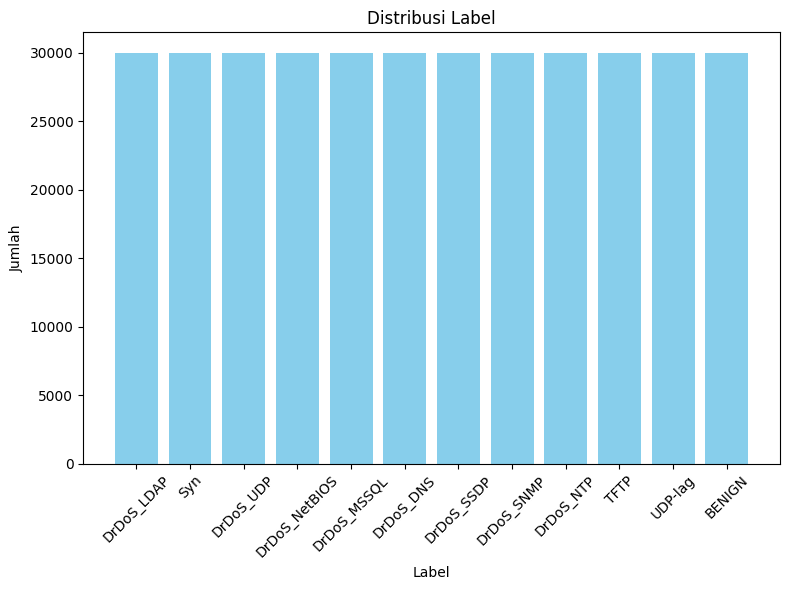

In [8]:
# Hitung jumlah masing-masing label
label_counts = df['Label'].value_counts()

# Buat bar chart
plt.figure(figsize=(8, 6))
plt.bar(label_counts.index, label_counts.values, color='skyblue')
plt.xlabel('Label')
plt.ylabel('Jumlah')
plt.title('Distribusi Label')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

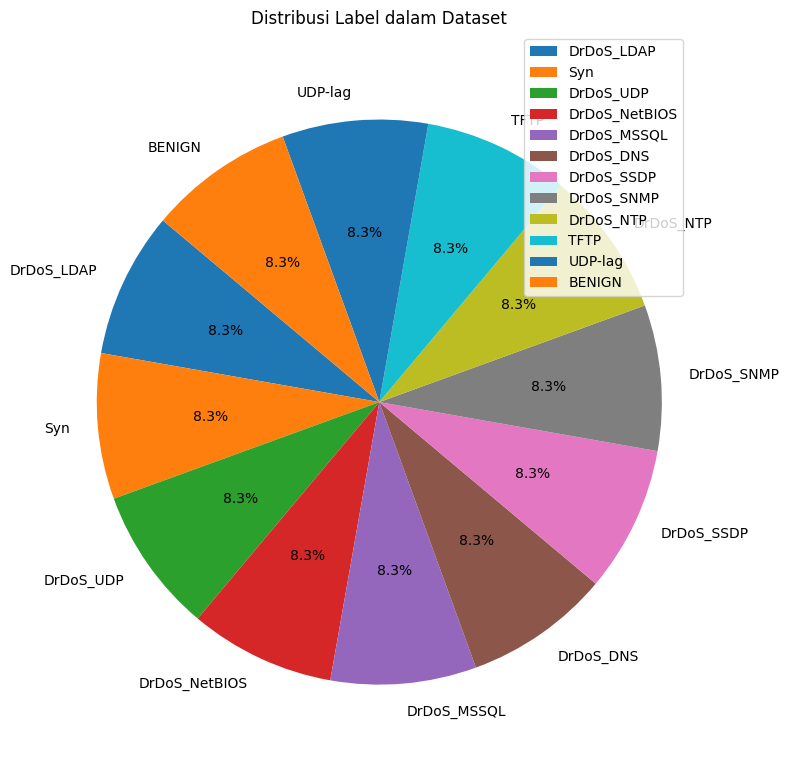

In [9]:
# Hitung jumlah masing-masing label
label_counts = df['Label'].value_counts()

# Buat pie chart
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140)
plt.legend()
plt.title('Distribusi Label dalam Dataset')
plt.axis('equal')  # Agar bentuk pie-nya bulat
plt.tight_layout()
plt.show()

In [10]:
# Menampilkan jumlah sample tiap protocol. '17' = UDP. '6' = TCP. '0' = HOPOPT (IPv6 Hop-by-Hop Option)
df['Protocol'].value_counts()

Protocol
17    285251
6      73805
0        944
Name: count, dtype: int64

### Drop and Encoding Label

In [11]:
df = df.drop(['Flow ID', 'Source IP', 'Destination IP', 'Source Port', 'Destination Port', 'Timestamp', 'SimillarHTTP', 'Fwd Header Length.1'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360000 entries, 0 to 359999
Data columns (total 80 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   360000 non-null  int64  
 1   Protocol                     360000 non-null  int64  
 2   Flow Duration                360000 non-null  int64  
 3   Total Fwd Packets            360000 non-null  int64  
 4   Total Backward Packets       360000 non-null  int64  
 5   Total Length of Fwd Packets  360000 non-null  float64
 6   Total Length of Bwd Packets  360000 non-null  float64
 7   Fwd Packet Length Max        360000 non-null  float64
 8   Fwd Packet Length Min        360000 non-null  float64
 9   Fwd Packet Length Mean       360000 non-null  float64
 10  Fwd Packet Length Std        360000 non-null  float64
 11  Bwd Packet Length Max        360000 non-null  float64
 12  Bwd Packet Length Min        360000 non-null  float64
 13 

In [12]:
# Pengubahan nilai dari string (kategorikal) ke numerik
le = LabelEncoder()
df['Label'] = le.fit_transform(df['Label'])

label_mapping = pd.DataFrame({
    'Original Label': le.classes_,
    'Encoded Value': range(len(le.classes_))
})

print("Mapping of original labels to encoded values:")
print(label_mapping)

Mapping of original labels to encoded values:
   Original Label  Encoded Value
0          BENIGN              0
1       DrDoS_DNS              1
2      DrDoS_LDAP              2
3     DrDoS_MSSQL              3
4       DrDoS_NTP              4
5   DrDoS_NetBIOS              5
6      DrDoS_SNMP              6
7      DrDoS_SSDP              7
8       DrDoS_UDP              8
9             Syn              9
10           TFTP             10
11        UDP-lag             11


In [13]:
# Menampilkan sampel data setelah encoding (sudah bernilai numerikal)
df.loc[:,['Label']].head()

Label
0      2
1      2
2      9
3      9
4      8

### X dan Y

In [14]:
X = df.drop(['Label'], axis=1)
y = df['Label']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

### Feature Selection Mutual Information

#### StandarScaler

In [16]:
categorical_features = ['Protocol', 'Inbound']
numerical_features = [col for col in X_train.columns if col not in categorical_features]

In [17]:
# Copy data asli untuk jaga-jaga
X_train_copy = X_train.copy()
X_test_copy = X_test.copy()

In [18]:
# Standarisasi fitur numerik saja
scaler = StandardScaler()

# Standarisasi hanya fitur numerik, simpan hasil ke variabel baru
X_train_scaled = X_train_copy.copy()
X_test_scaled = X_test_copy.copy()

X_train_scaled[numerical_features] = scaler.fit_transform(X_train_copy[numerical_features])
X_test_scaled[numerical_features] = scaler.transform(X_test_copy[numerical_features])

In [19]:
# Opsional: Kalau mau konversi ke array, tinggal pakai
X_train_scaled_array = X_train_scaled.to_numpy()
X_test_scaled_array = X_test_scaled.to_numpy()

#### Mutual Information

##### MI + NB

[CV] END ..................., score=(train=0.516, test=0.516) total time=  40.8s
[CV] END ..................., score=(train=0.518, test=0.516) total time=  39.7s
[CV] END ..................., score=(train=0.515, test=0.516) total time=  38.5s
[CV] END ..................., score=(train=0.523, test=0.523) total time=  38.4s
[CV] END ..................., score=(train=0.538, test=0.537) total time=  38.4s
[CV] END ..................., score=(train=0.521, test=0.522) total time=  38.3s
[CV] END ..................., score=(train=0.509, test=0.509) total time=  38.2s
[CV] END ..................., score=(train=0.515, test=0.513) total time=  38.5s
[CV] END ..................., score=(train=0.508, test=0.512) total time=  38.9s
[CV] END ..................., score=(train=0.472, test=0.470) total time=  38.9s
[CV] END ..................., score=(train=0.500, test=0.499) total time=  38.8s
[CV] END ..................., score=(train=0.498, test=0.499) total time=  38.7s
[CV] END ...................

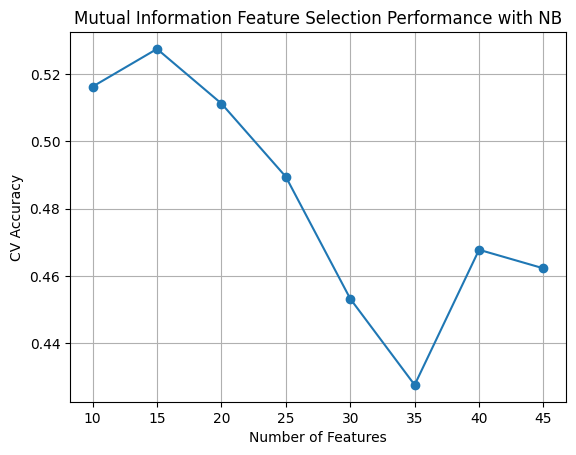

In [18]:
scores_mi = []
k_range = range(10, 50, 5)

model_mi = GaussianNB()

for k in k_range:
    # Pipeline untuk feature selection + model
    model = Pipeline([
        ('select', SelectKBest(score_func=mutual_info_classif, k=k)),
        ('clf', model_mi)
    ])

    # Validasi silang yang aman (tidak ada data leakage)
    results = cross_validate(model, X_train_scaled, y_train, cv=3, scoring='accuracy', return_train_score=True, verbose=3)
    mean_test_score = results['test_score'].mean()
    scores_mi.append(mean_test_score)

# Plot
plt.plot(k_range, scores_mi, marker='o')
plt.xlabel("Number of Features")
plt.ylabel("CV Accuracy")
plt.title("Mutual Information Feature Selection Performance with NB")
plt.grid(True)
plt.show()

##### MI + kNN

[CV] END ..................., score=(train=0.638, test=0.636) total time=  55.2s
[CV] END ..................., score=(train=0.649, test=0.648) total time=  54.6s
[CV] END ..................., score=(train=0.649, test=0.648) total time=  55.5s
[CV] END ..................., score=(train=0.719, test=0.711) total time=  50.9s
[CV] END ..................., score=(train=0.732, test=0.725) total time=  51.9s
[CV] END ..................., score=(train=0.732, test=0.725) total time=  52.5s
[CV] END ..................., score=(train=0.784, test=0.757) total time=  46.6s
[CV] END ..................., score=(train=0.784, test=0.756) total time=  47.3s
[CV] END ..................., score=(train=0.783, test=0.758) total time=  47.1s
[CV] END ..................., score=(train=0.786, test=0.759) total time=  48.2s
[CV] END ..................., score=(train=0.786, test=0.758) total time=  47.8s
[CV] END ..................., score=(train=0.785, test=0.758) total time=  47.5s
[CV] END ...................

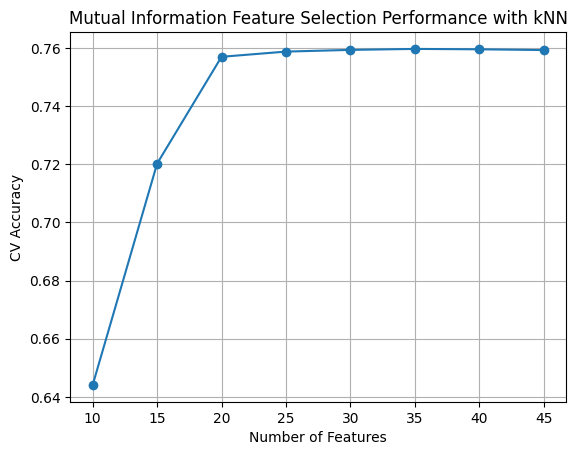

In [19]:
scores_mi = []
k_range = range(10, 50, 5)

model_mi = KNeighborsClassifier(n_neighbors=30)

for k in k_range:
    # Pipeline untuk feature selection + model
    model = Pipeline([
        ('select', SelectKBest(score_func=mutual_info_classif, k=k)),
        ('clf', model_mi)
    ])

    # Validasi silang yang aman (tidak ada data leakage)
    results = cross_validate(model, X_train_scaled, y_train, cv=3, scoring='accuracy', return_train_score=True, verbose=3)
    mean_test_score = results['test_score'].mean()
    scores_mi.append(mean_test_score)

# Plot
plt.plot(k_range, scores_mi, marker='o')
plt.xlabel("Number of Features")
plt.ylabel("CV Accuracy")
plt.title("Mutual Information Feature Selection Performance with kNN")
plt.grid(True)
plt.show()

##### MI + Random Forest

[CV] END ..................., score=(train=0.669, test=0.667) total time=  50.2s
[CV] END ..................., score=(train=0.668, test=0.667) total time=  49.2s
[CV] END ..................., score=(train=0.669, test=0.666) total time=  48.2s
[CV] END ..................., score=(train=0.781, test=0.735) total time=  52.6s
[CV] END ..................., score=(train=0.781, test=0.735) total time=  52.0s
[CV] END ..................., score=(train=0.780, test=0.737) total time=  51.5s
[CV] END ..................., score=(train=0.986, test=0.751) total time= 1.2min
[CV] END ..................., score=(train=0.986, test=0.747) total time= 1.2min
[CV] END ..................., score=(train=0.986, test=0.747) total time= 1.2min
[CV] END ..................., score=(train=0.996, test=0.761) total time= 1.2min
[CV] END ..................., score=(train=0.996, test=0.760) total time= 1.2min
[CV] END ..................., score=(train=0.996, test=0.759) total time= 1.2min
[CV] END ...................

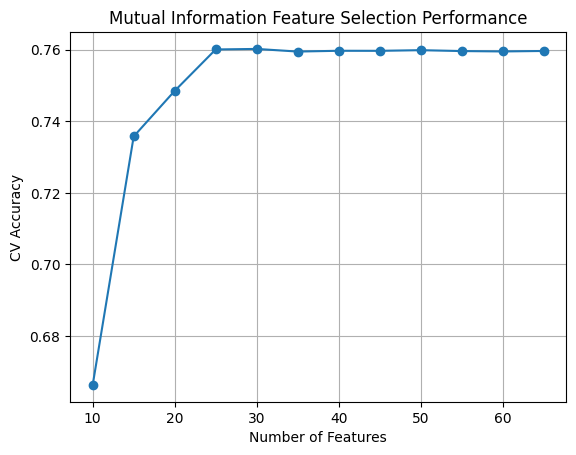

In [ ]:
scores_mi = []
k_range = range(10, 70, 5)

model_mi = RandomForestClassifier(random_state=42)

for k in k_range:
    # Pipeline untuk feature selection + model
    model = Pipeline([
        ('select', SelectKBest(score_func=mutual_info_classif, k=k)),
        ('clf', RandomForestClassifier(random_state=42))
    ])

    # Validasi silang yang aman (tidak ada data leakage)
    results = cross_validate(model, X_train_scaled, y_train, cv=3, scoring='accuracy', return_train_score=True, verbose=3)
    mean_test_score = results['test_score'].mean()
    scores_mi.append(mean_test_score)

# Plot
plt.plot(k_range, scores_mi, marker='o')
plt.xlabel("Number of Features")
plt.ylabel("CV Accuracy")
plt.title("Mutual Information Feature Selection Performance")
plt.grid(True)
plt.show()

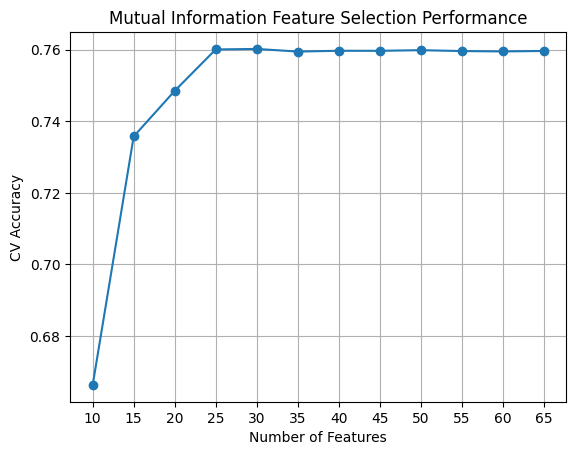

In [21]:
# Plot
plt.plot(k_range, scores_mi, marker='o')
plt.xlabel("Number of Features")
plt.ylabel("CV Accuracy")
plt.title("Mutual Information Feature Selection Performance")
plt.grid(True)
plt.xticks(k_range) 
plt.show()

#### Selected Features with MI

In [21]:
# Menentukan jumlah fitur yang ingin dipertahankan
num_features_to_retain = 25

# Menghitung skor mutual information hanya pada data latih yang sudah distandarisasi
mi_scores = mutual_info_classif(X_train_scaled_array, y_train)

# Mendapatkan indeks fitur-fitur dengan skor tertinggi
selected_features = np.argsort(mi_scores)[-num_features_to_retain:]

# Menampilkan indeks fitur terpilih
print("Selected feature indices:", selected_features)

Selected feature indices: [66 23 35 24 22 18 21  0 19 68  2 17 37 16 39 15  8 63  5  7  9 54 53 40
 41]


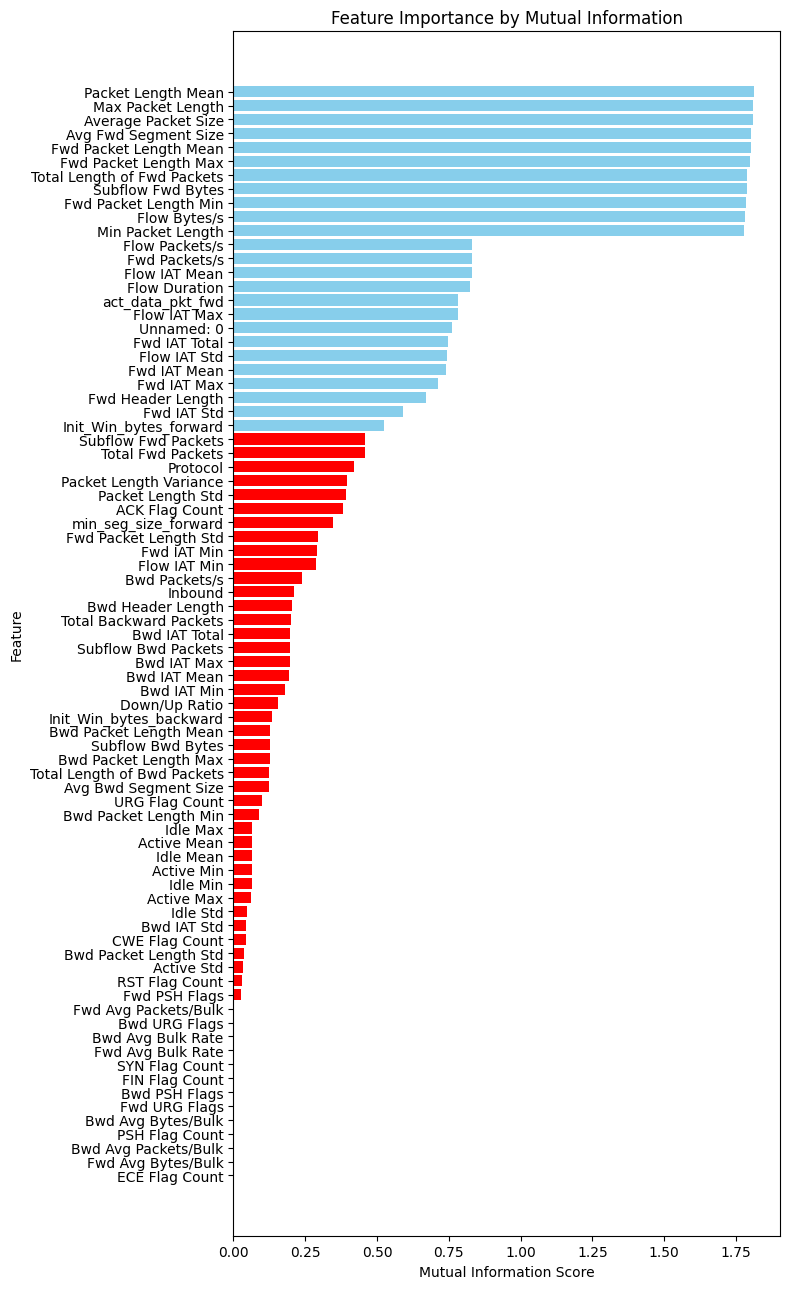

In [22]:
feature_names = X_train_scaled.columns

# Buat DataFrame untuk visualisasi skor MI
ranking_df = pd.DataFrame({
    'Feature': feature_names,
    'MI Score': mi_scores
}).sort_values(by='MI Score', ascending=False)

# Warnai bar merah untuk fitur yang terpilih, biru lainnya
colors = ['skyblue' if i in selected_features else 'red' for i in ranking_df.index]

plt.figure(figsize=(8, 13))
plt.barh(ranking_df['Feature'], ranking_df['MI Score'], color=colors)
plt.xlabel('Mutual Information Score')
plt.ylabel('Feature')
plt.title('Feature Importance by Mutual Information')
plt.gca().invert_yaxis()  # Biar fitur dengan skor tertinggi di atas
plt.tight_layout()
plt.show()

In [20]:
selected_features = [66, 23, 35, 24, 22, 18, 21, 0, 19, 68, 2, 17, 16, 37, 39, 15,  8, 63, 5, 7, 9, 54, 40, 53, 41]

In [21]:
X_train_selected_scaled_df = X_train_scaled.iloc[:, selected_features]
X_test_selected_scaled_df = X_test_scaled.iloc[:, selected_features]

In [22]:
X_train_selected_scaled = X_train_scaled_array[:, selected_features]
X_test_selected_scaled = X_test_scaled_array[:, selected_features]

In [ ]:
# Ambil nama fitur yang dipilih dari selected_features (indeks)
selected_feature_names = feature_names[selected_features]

print(f"Jumlah fitur terpilih: {selected_feature_names.size}")
selected_feature_names.to_list()

### Modeling with Feature Selection

In [26]:
def evaluate_model(model, X_test, y_test, name="Model"):
    # Waktu prediksi
    start_pred = time.time()
    y_pred = model.predict(X_test)
    end_pred = time.time()
    prediction_time = end_pred - start_pred
    print(f"Waktu prediksi ({name}): {prediction_time:.4f} detik")

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix - {name}')
    plt.show()

    # Classification report
    print(classification_report(y_test, y_pred, zero_division=0))

In [23]:
def evaluate_model_2(model, X_test, y_test, name="Model"):
    # Waktu prediksi
    start_pred = time.time()
    y_pred = model.predict(X_test)
    end_pred = time.time()
    prediction_time = end_pred - start_pred
    print(f"Waktu prediksi ({name}): {prediction_time:.4f} detik")

    # Hitung metrik evaluasi
    acc = accuracy_score(y_test, y_pred.round())
    prec = precision_score(y_test, y_pred.round(), average='macro', zero_division=0)
    rec = recall_score(y_test, y_pred.round(), average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred.round(), average='macro', zero_division=0)

    print(f"accuracy: {acc}")
    print(f"precision: {prec}")
    print(f"recall: {rec}")
    print(f"f1-score: {f1}")

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix - {name}')
    plt.show()

    # Classification report
    print(classification_report(y_test, y_pred, zero_division=0))

In [ ]:
models = {
    "KNN": KNeighborsClassifier(metric= 'minkowski', n_neighbors= 9, p= 1, weights= 'uniform'),
    "Naive Bayes": GaussianNB(var_smoothing= np.float64(1e-06)),
    "Logistic Regression": LogisticRegression(max_iter=5000, C= 10, penalty= 'l2', solver= 'newton-cg'),
    "Decision Tree": DecisionTreeClassifier(criterion= 'entropy', max_depth= 10, max_features= None, min_samples_leaf= 2, min_samples_split= 2,  random_state=42),
    "SVM": SVC(kernel='rbf', C=10, gamma='scale', random_state=42),
    "XGB": xgb.XGBClassifier(tree_method="hist", n_estimators=300,gamma=0.3, learning_rate=0.1, max_depth=5, reg_alpha=0.01, reg_lambda=2, random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=300, max_depth=20, max_features="log2", min_samples_leaf=4, random_state=42),
    "AdaBoost": AdaBoostClassifier(learning_rate= 1, n_estimators= 300)
}

#### Ensemble Learning

##### LSTM, RF, KNN -> LR based on paper 5

In [ ]:
# Definisikan base learner (bisa ditambah jika mau)
start_train = time.time()

base_learners = [
    ("RF", RandomForestClassifier(max_depth= 20, max_features= 'log2', min_samples_leaf= 4, n_estimators= 300, random_state=42)),
    ("KNN", KNeighborsClassifier(metric= 'minkowski', n_neighbors= 9, p= 1, weights= 'uniform'))
]

# Definisikan meta learner
meta_learner =  LogisticRegression(solver= 'newton-cg', penalty= 'l2', C=10, max_iter=5000)

# Definisikan Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=3,
    n_jobs=-1,
    passthrough=True,  # kalau True, input fitur asli juga masuk ke meta-learner
    verbose=3
)

# Latih model stacking
stacking_clf.fit(X_train_selected_scaled, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan Stacking base-learner(RF + KNN) + meta-learner(LR): {training_time:.4f} detik")

# Prediksi dan evaluasi
evaluate_model_2(stacking_clf, X_test_selected_scaled, y_test, name="Stacking base-learner(SVM + NB + DT + RF) + meta-learner(LR)")

##### Stacking SVM + NB + DT + RF -> LR (based on paper 4)

In [ ]:
# Definisikan base learner (bisa ditambah jika mau)
start_train = time.time()

base_learners = [
    ("SVM", SVC(kernel='rbf', C=10, gamma='scale', random_state=42)),
    ("NB", GaussianNB(var_smoothing= np.float64(1e-06))),
    ("DT", DecisionTreeClassifier(criterion= 'entropy', max_depth= 10, max_features= None, min_samples_leaf= 2, min_samples_split= 2, random_state=42)),
    ("RF", RandomForestClassifier(max_depth= 20, max_features= 'log2', min_samples_leaf= 4, n_estimators= 300, random_state=42)),
]

# Definisikan meta learner
meta_learner =  LogisticRegression(solver= 'newton-cg', penalty= 'l2', C=10, max_iter=5000)

# Definisikan Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=3,
    n_jobs=-1,
    passthrough=True,  # kalau True, input fitur asli juga masuk ke meta-learner
    verbose=3
)

# Latih model stacking
stacking_clf.fit(X_train_selected_scaled, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan Stacking base-learner(SVM + NB + DT + RF) + meta-learner(LR): {training_time:.4f} detik")

# Prediksi dan evaluasi
evaluate_model_2(stacking_clf, X_test_selected_scaled, y_test, name="Stacking base-learner(SVM + NB + DT + RF) + meta-learner(LR)")

Waktu pelatihan Stacking base-learner(SVM + NB + DT + RF) + meta-learner(LR): 2212.2019 detik


NameError: name 'evaluate_model' is not defined

Waktu prediksi (Stacking base-learner(SVM + NB + DT + RF) + meta-learner(LR)): 1201.2766 detik
accuracy: 0.7942314814814815
precision: 0.802416215522054
recall: 0.7942314814814814
f1-score: 0.790558968045712


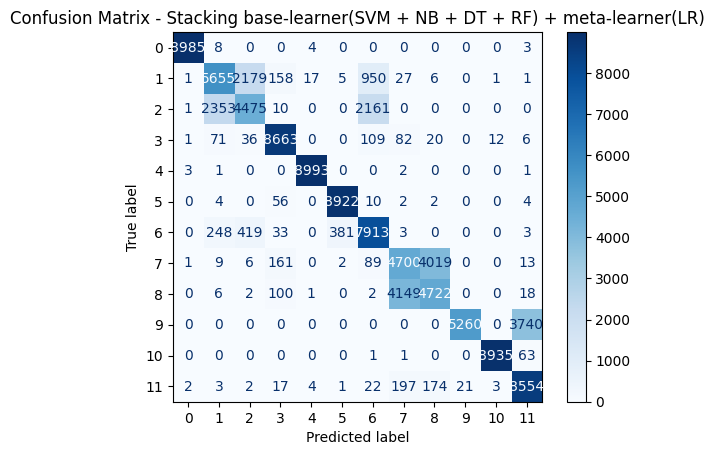

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9000
           1       0.68      0.63      0.65      9000
           2       0.63      0.50      0.56      9000
           3       0.94      0.96      0.95      9000
           4       1.00      1.00      1.00      9000
           5       0.96      0.99      0.97      9000
           6       0.70      0.88      0.78      9000
           7       0.51      0.52      0.52      9000
           8       0.53      0.52      0.53      9000
           9       1.00      0.58      0.74      9000
          10       1.00      0.99      1.00      9000
          11       0.69      0.95      0.80      9000

    accuracy                           0.79    108000
   macro avg       0.80      0.79      0.79    108000
weighted avg       0.80      0.79      0.79    108000



In [41]:
evaluate_model_2(stacking_clf, X_test_selected_scaled, y_test, name="Stacking base-learner(SVM + NB + DT + RF) + meta-learner(LR)")

Waktu pelatihan Stacking base-learner(SVM + NB + DT + RF) + meta-learner(LR): 2071.2914 detik
Waktu prediksi (Stacking base-learner(SVM + NB + DT + RF) + meta-learner(LR)): 2152.4257 detik
accuracy: 0.7940277777777778
precision: 0.8019125263839194
recall: 0.794027777777778
f1-score: 0.79017343754516


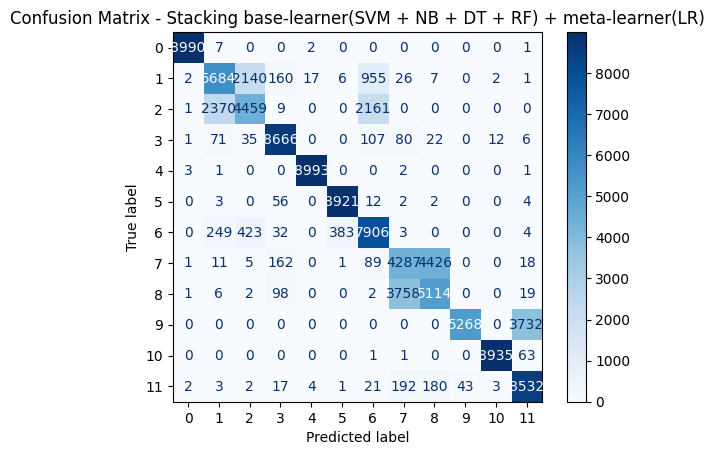

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9000
           1       0.68      0.63      0.65      9000
           2       0.63      0.50      0.56      9000
           3       0.94      0.96      0.95      9000
           4       1.00      1.00      1.00      9000
           5       0.96      0.99      0.97      9000
           6       0.70      0.88      0.78      9000
           7       0.51      0.48      0.49      9000
           8       0.52      0.57      0.55      9000
           9       0.99      0.59      0.74      9000
          10       1.00      0.99      1.00      9000
          11       0.69      0.95      0.80      9000

    accuracy                           0.79    108000
   macro avg       0.80      0.79      0.79    108000
weighted avg       0.80      0.79      0.79    108000



In [42]:
# Definisikan base learner (bisa ditambah jika mau)
start_train = time.time()

base_learners = [
    ("SVM", SVC(kernel='rbf', C=10, gamma='scale', random_state=42)),
    ("NB", GaussianNB(var_smoothing= np.float64(1e-06))),
    ("DT", DecisionTreeClassifier(criterion= 'entropy', max_depth= 10, max_features= None, min_samples_leaf= 2, min_samples_split= 2, random_state=42)),
    ("RF", RandomForestClassifier(max_depth= 20, max_features= 'log2', min_samples_leaf= 4, n_estimators= 300, random_state=42)),
]

# Definisikan meta learner
meta_learner =  LogisticRegression(solver= 'newton-cg', penalty= 'l2', C=10, max_iter=5000)

# Definisikan Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=3,
    n_jobs=-1,
    passthrough=False,  # kalau True, input fitur asli juga masuk ke meta-learner
    verbose=3
)

# Latih model stacking
stacking_clf.fit(X_train_selected_scaled, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan Stacking base-learner(SVM + NB + DT + RF) + meta-learner(LR): {training_time:.4f} detik")

# Prediksi dan evaluasi
evaluate_model_2(stacking_clf, X_test_selected_scaled, y_test, name="Stacking base-learner(SVM + NB + DT + RF) + meta-learner(LR)")

##### Stacking RF + AB + XGB + DT -> RF (Proposed Model)

Waktu pelatihan (Stacking base-learner(XGB + RF + AB + DT) + meta-learner (RF)): 548.1914 detik
Waktu prediksi (Stacking base-learner(XGB + RF + AB + DT) + meta-learner (RF)): 15.5993 detik
accuracy: 0.7949537037037037
precision: 0.8046268416006942
recall: 0.7949537037037038
f1-score: 0.7863014889037653


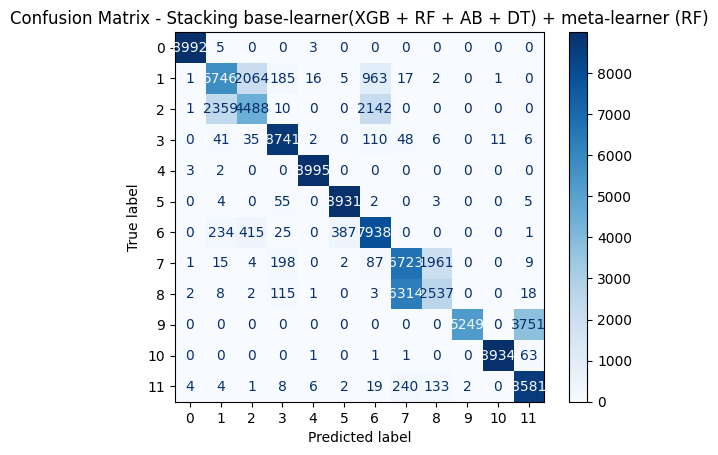

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9000
           1       0.68      0.64      0.66      9000
           2       0.64      0.50      0.56      9000
           3       0.94      0.97      0.95      9000
           4       1.00      1.00      1.00      9000
           5       0.96      0.99      0.97      9000
           6       0.70      0.88      0.78      9000
           7       0.50      0.75      0.60      9000
           8       0.55      0.28      0.37      9000
           9       1.00      0.58      0.74      9000
          10       1.00      0.99      1.00      9000
          11       0.69      0.95      0.80      9000

    accuracy                           0.79    108000
   macro avg       0.80      0.79      0.79    108000
weighted avg       0.80      0.79      0.79    108000



In [36]:
# Definisikan base learner (bisa ditambah jika mau)
start_train = time.time()

base_learners = [
    ("XGB", xgb.XGBClassifier(tree_method="hist", n_estimators=300,gamma=0.3, learning_rate=0.1, max_depth=5, reg_alpha=0.01, reg_lambda=2, random_state=42)),
    ("RF", RandomForestClassifier(n_estimators=300, max_depth=20, max_features="log2", min_samples_leaf=4, random_state=42)),
    ("AB", AdaBoostClassifier(learning_rate= 1, n_estimators= 300, random_state=42)),
    ("DT", DecisionTreeClassifier(criterion= 'entropy', max_depth= 10, max_features= None, min_samples_leaf= 2, min_samples_split= 2, random_state=42))
]

# Definisikan meta learner
meta_learner = RandomForestClassifier(n_estimators=300, max_depth=20, max_features="log2", min_samples_leaf=4, random_state=42)

# Definisikan Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=3,
    n_jobs=-1,
    passthrough=True,  # kalau True, input fitur asli juga masuk ke meta-learner
    verbose=3
)

# Latih model stacking
stacking_clf.fit(X_train_selected_scaled, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (Stacking base-learner(XGB + RF + AB + DT) + meta-learner (RF)): {training_time:.4f} detik")

# Prediksi dan evaluasi
evaluate_model_2(stacking_clf, X_test_selected_scaled, y_test, name="Stacking base-learner(XGB + RF + AB + DT) + meta-learner (RF)")

Waktu pelatihan (Stacking base-learner(XGB + RF + AB + DT) + meta-learner (RF)): 520.1787 detik
Waktu prediksi (Stacking base-learner(XGB + RF + AB + DT) + meta-learner (RF)): 14.3472 detik
accuracy: 0.7938703703703703
precision: 0.8039519212351509
recall: 0.7938703703703703
f1-score: 0.7830450304116461


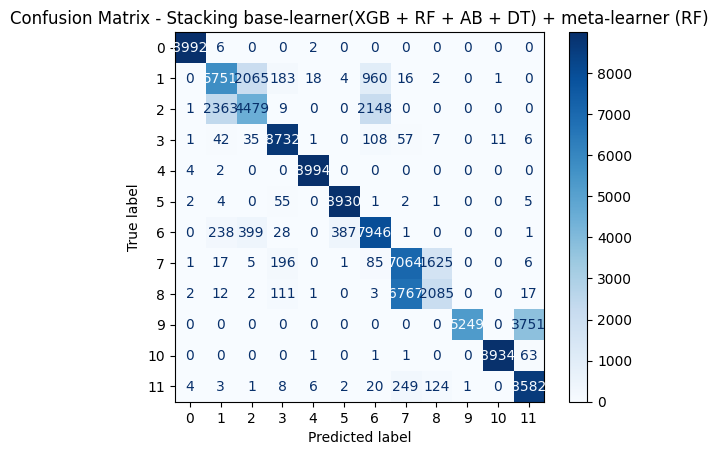

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9000
           1       0.68      0.64      0.66      9000
           2       0.64      0.50      0.56      9000
           3       0.94      0.97      0.95      9000
           4       1.00      1.00      1.00      9000
           5       0.96      0.99      0.97      9000
           6       0.70      0.88      0.78      9000
           7       0.50      0.78      0.61      9000
           8       0.54      0.23      0.32      9000
           9       1.00      0.58      0.74      9000
          10       1.00      0.99      1.00      9000
          11       0.69      0.95      0.80      9000

    accuracy                           0.79    108000
   macro avg       0.80      0.79      0.78    108000
weighted avg       0.80      0.79      0.78    108000



In [37]:
# Definisikan base learner (bisa ditambah jika mau)
start_train = time.time()

base_learners = [
    ("XGB", xgb.XGBClassifier(tree_method="hist", n_estimators=300,gamma=0.3, learning_rate=0.1, max_depth=5, reg_alpha=0.01, reg_lambda=2, random_state=42)),
    ("RF", RandomForestClassifier(n_estimators=300, max_depth=20, max_features="log2", min_samples_leaf=4, random_state=42)),
    ("AB", AdaBoostClassifier(learning_rate= 1, n_estimators= 300, random_state=42)),
    ("DT", DecisionTreeClassifier(criterion= 'entropy', max_depth= 10, max_features= None, min_samples_leaf= 2, min_samples_split= 2, random_state=42))
]

# Definisikan meta learner
meta_learner = RandomForestClassifier(n_estimators=300, max_depth=20, max_features="log2", min_samples_leaf=4, random_state=42)

# Definisikan Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=3,
    n_jobs=-1,
    passthrough=False,  # kalau True, input fitur asli juga masuk ke meta-learner
    verbose=3
)

# Latih model stacking
stacking_clf.fit(X_train_selected_scaled, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (Stacking base-learner(XGB + RF + AB + DT) + meta-learner (RF)): {training_time:.4f} detik")

# Prediksi dan evaluasi
evaluate_model_2(stacking_clf, X_test_selected_scaled, y_test, name="Stacking base-learner(XGB + RF + AB + DT) + meta-learner (RF)")

##### Stacking RF + AB + XGB + DT -> LR (Proposed Model)

Waktu pelatihan (Stacking base-learner(XGB + RF + AB + DT) + meta-learner (LR)): 469.9821 detik
Waktu prediksi (Stacking base-learner(XGB + RF + AB + DT) + meta-learner (LR)): 10.7330 detik
accuracy: 0.7958240740740741
precision: 0.8039465284658779
recall: 0.7958240740740741
f1-score: 0.7924151633223886


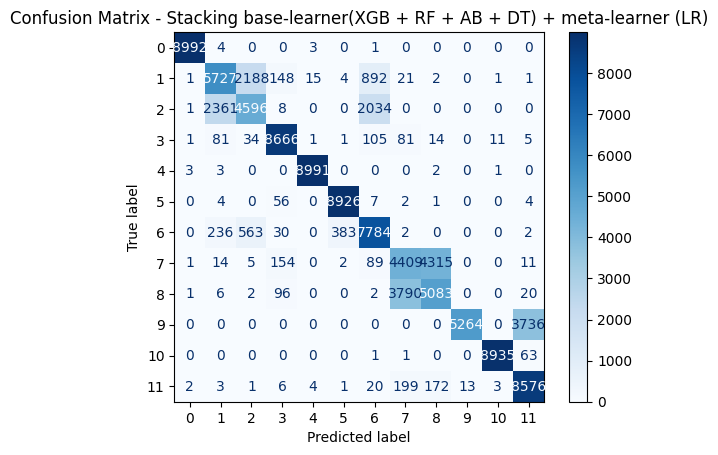

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9000
           1       0.68      0.64      0.66      9000
           2       0.62      0.51      0.56      9000
           3       0.95      0.96      0.95      9000
           4       1.00      1.00      1.00      9000
           5       0.96      0.99      0.97      9000
           6       0.71      0.86      0.78      9000
           7       0.52      0.49      0.50      9000
           8       0.53      0.56      0.55      9000
           9       1.00      0.58      0.74      9000
          10       1.00      0.99      1.00      9000
          11       0.69      0.95      0.80      9000

    accuracy                           0.80    108000
   macro avg       0.80      0.80      0.79    108000
weighted avg       0.80      0.80      0.79    108000



In [34]:
# Definisikan base learner (bisa ditambah jika mau)
start_train = time.time()

base_learners = [
    ("XGB", xgb.XGBClassifier(tree_method="hist", n_estimators=300,gamma=0.3, learning_rate=0.1, max_depth=5, reg_alpha=0.01, reg_lambda=2, random_state=42)),
    ("RF", RandomForestClassifier(n_estimators=300, max_depth=20, max_features="log2", min_samples_leaf=4, random_state=42)),
    ("AB", AdaBoostClassifier(learning_rate= 1, n_estimators= 300, random_state=42)),
    ("DT", DecisionTreeClassifier(criterion= 'entropy', max_depth= 10, max_features= None, min_samples_leaf= 2, min_samples_split= 2, random_state=42))
]

# Definisikan meta learner
meta_learner = LogisticRegression(max_iter=5000, penalty= None, solver= 'newton-cg')

# Definisikan Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=3,
    n_jobs=-1,
    passthrough=True,  # kalau True, input fitur asli juga masuk ke meta-learner
    verbose=3
)

# Latih model stacking
stacking_clf.fit(X_train_selected_scaled, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (Stacking base-learner(XGB + RF + AB + DT) + meta-learner (LR)): {training_time:.4f} detik")

# Prediksi dan evaluasi
evaluate_model_2(stacking_clf, X_test_selected_scaled, y_test, name="Stacking base-learner(XGB + RF + AB + DT) + meta-learner (LR)")

Waktu pelatihan (Stacking base-learner(XGB + RF + AB + DT) + meta-learner (LR)): 291.8313 detik
Waktu prediksi (Stacking base-learner(XGB + RF + AB + DT) + meta-learner (LR)): 10.0983 detik
accuracy: 0.7965092592592593
precision: 0.8043707239535155
recall: 0.7965092592592592
f1-score: 0.7928157669601119


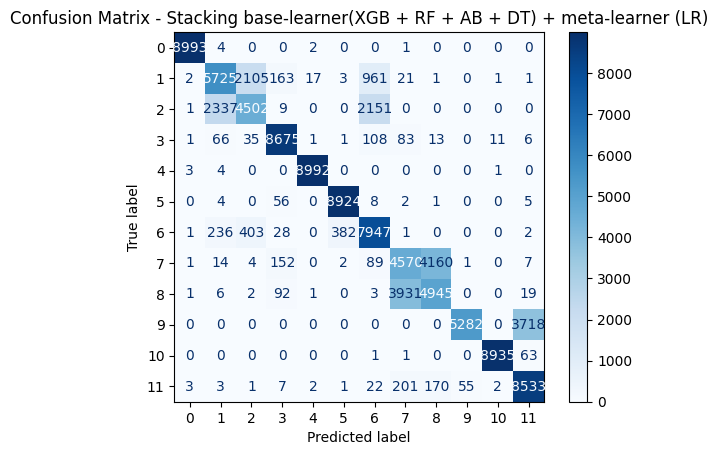

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9000
           1       0.68      0.64      0.66      9000
           2       0.64      0.50      0.56      9000
           3       0.94      0.96      0.95      9000
           4       1.00      1.00      1.00      9000
           5       0.96      0.99      0.97      9000
           6       0.70      0.88      0.78      9000
           7       0.52      0.51      0.51      9000
           8       0.53      0.55      0.54      9000
           9       0.99      0.59      0.74      9000
          10       1.00      0.99      1.00      9000
          11       0.69      0.95      0.80      9000

    accuracy                           0.80    108000
   macro avg       0.80      0.80      0.79    108000
weighted avg       0.80      0.80      0.79    108000



In [35]:
# Definisikan base learner (bisa ditambah jika mau)
start_train = time.time()

base_learners = [
    ("XGB", xgb.XGBClassifier(tree_method="hist", n_estimators=300,gamma=0.3, learning_rate=0.1, max_depth=5, reg_alpha=0.01, reg_lambda=2, random_state=42)),
    ("RF", RandomForestClassifier(n_estimators=300, max_depth=20, max_features="log2", min_samples_leaf=4, random_state=42)),
    ("AB", AdaBoostClassifier(learning_rate= 1, n_estimators= 300, random_state=42)),
    ("DT", DecisionTreeClassifier(criterion= 'entropy', max_depth= 10, max_features= None, min_samples_leaf= 2, min_samples_split= 2, random_state=42))
]

# Definisikan meta learner
meta_learner = LogisticRegression(max_iter=5000, penalty= None, solver= 'newton-cg')

# Definisikan Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=3,
    n_jobs=-1,
    passthrough=False,  # kalau True, input fitur asli juga masuk ke meta-learner
    verbose=3
)

# Latih model stacking
stacking_clf.fit(X_train_selected_scaled, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (Stacking base-learner(XGB + RF + AB + DT) + meta-learner (LR)): {training_time:.4f} detik")

# Prediksi dan evaluasi
evaluate_model_2(stacking_clf, X_test_selected_scaled, y_test, name="Stacking base-learner(XGB + RF + AB + DT) + meta-learner (LR)")

##### RF + XGB + Extraa Tree Classifier (based on paper 2)

Waktu pelatihan (Stacking base-learner (RF + XGB) + meta-learner(LR)): 308.2199 detik
Waktu prediksi (Stacking base-learner(RF + XGB) + meta-learner(LR)): 3.9923 detik
accuracy: 0.7955185185185185
precision: 0.8016481556766063
recall: 0.7955185185185186
f1-score: 0.792270686658609


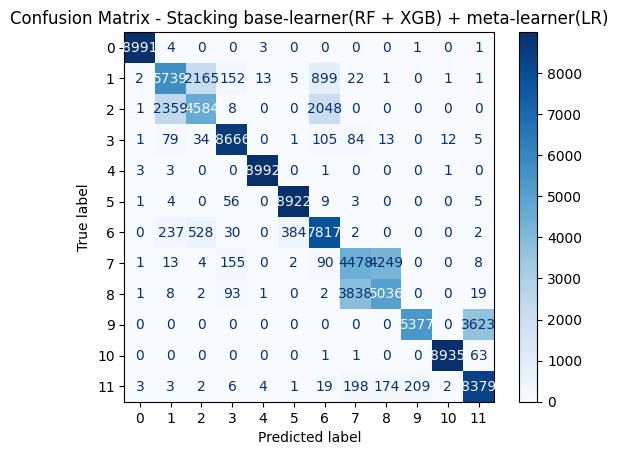

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9000
           1       0.68      0.64      0.66      9000
           2       0.63      0.51      0.56      9000
           3       0.95      0.96      0.95      9000
           4       1.00      1.00      1.00      9000
           5       0.96      0.99      0.97      9000
           6       0.71      0.87      0.78      9000
           7       0.52      0.50      0.51      9000
           8       0.53      0.56      0.55      9000
           9       0.96      0.60      0.74      9000
          10       1.00      0.99      1.00      9000
          11       0.69      0.93      0.79      9000

    accuracy                           0.80    108000
   macro avg       0.80      0.80      0.79    108000
weighted avg       0.80      0.80      0.79    108000



In [33]:
# Definisikan base learner (bisa ditambah jika mau)
start_train = time.time()

base_learners = [
    ("RF", RandomForestClassifier(n_estimators=300, max_depth=20, max_features="log2", min_samples_leaf=4, random_state=42)),
    ("XGB", xgb.XGBClassifier(tree_method="hist", gamma= 0.3, learning_rate= 0.1, max_depth= 5, n_estimators= 300, reg_alpha= 0.01, reg_lambda= 2, random_state=42))
]

# Definisikan meta learner
meta_learner = LogisticRegression(max_iter=5000, C= 10, penalty= 'l2', solver= 'newton-cg')

# Definisikan Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=3,
    n_jobs=-1,
    passthrough=True,  # kalau True, input fitur asli juga masuk ke meta-learner
    verbose=3
)

# Latih model stacking
stacking_clf.fit(X_train_selected_scaled, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (Stacking base-learner (RF + XGB) + meta-learner(LR)): {training_time:.4f} detik")

# Prediksi dan evaluasi
evaluate_model_2(stacking_clf, X_test_selected_scaled, y_test, name="Stacking base-learner(RF + XGB) + meta-learner(LR)")

Waktu pelatihan (Stacking base-learner (RF + XGB) + meta-learner(LR)): 197.0487 detik
Waktu prediksi (Stacking base-learner(RF + XGB) + meta-learner(LR)): 4.1262 detik
accuracy: 0.795787037037037
precision: 0.8017954147141185
recall: 0.7957870370370371
f1-score: 0.7922800920761487


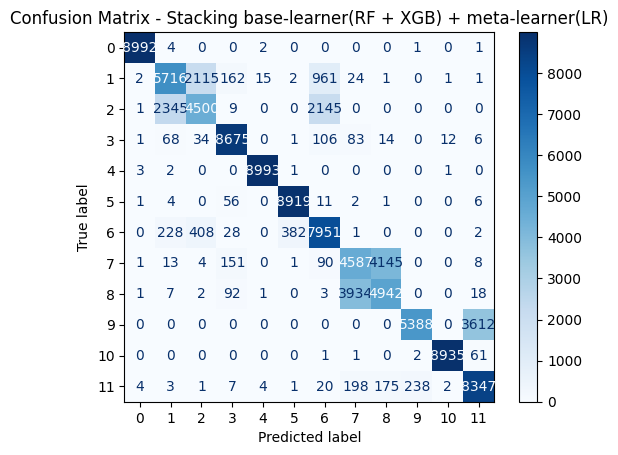

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9000
           1       0.68      0.64      0.66      9000
           2       0.64      0.50      0.56      9000
           3       0.94      0.96      0.95      9000
           4       1.00      1.00      1.00      9000
           5       0.96      0.99      0.97      9000
           6       0.70      0.88      0.78      9000
           7       0.52      0.51      0.51      9000
           8       0.53      0.55      0.54      9000
           9       0.96      0.60      0.74      9000
          10       1.00      0.99      1.00      9000
          11       0.69      0.93      0.79      9000

    accuracy                           0.80    108000
   macro avg       0.80      0.80      0.79    108000
weighted avg       0.80      0.80      0.79    108000



In [34]:
# Definisikan base learner (bisa ditambah jika mau)
start_train = time.time()

base_learners = [
    ("RF", RandomForestClassifier(n_estimators=300, max_depth=20, max_features="log2", min_samples_leaf=4, random_state=42)),
    ("XGB", xgb.XGBClassifier(tree_method="hist", gamma= 0.3, learning_rate= 0.1, max_depth= 5, n_estimators= 300, reg_alpha= 0.01, reg_lambda= 2, random_state=42))
]

# Definisikan meta learner
meta_learner = LogisticRegression(max_iter=5000, C= 10, penalty= 'l2', solver= 'newton-cg')

# Definisikan Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=3,
    n_jobs=-1,
    passthrough=False,  # kalau True, input fitur asli juga masuk ke meta-learner
    verbose=3
)

# Latih model stacking
stacking_clf.fit(X_train_selected_scaled, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (Stacking base-learner (RF + XGB) + meta-learner(LR)): {training_time:.4f} detik")

# Prediksi dan evaluasi
evaluate_model_2(stacking_clf, X_test_selected_scaled, y_test, name="Stacking base-learner(RF + XGB) + meta-learner(LR)")

##### LR, SVM, RF, KNN, DT, XGBoost	-> LR (based on Paper 1)

Waktu pelatihan (Stacking base-learner(LR + SVM + RF + KNN + DT + XGB) + meta-learner(XGB)): 2218.6114 detik
Waktu prediksi (Stacking base-learner(LR + SVM + RF + KNN + DT + XGB) + meta-learner(LR)): 1152.4082 detik
accuracy: 0.7966018518518518
precision: 0.8047613435766244
recall: 0.796601851851852
f1-score: 0.7928337065133655


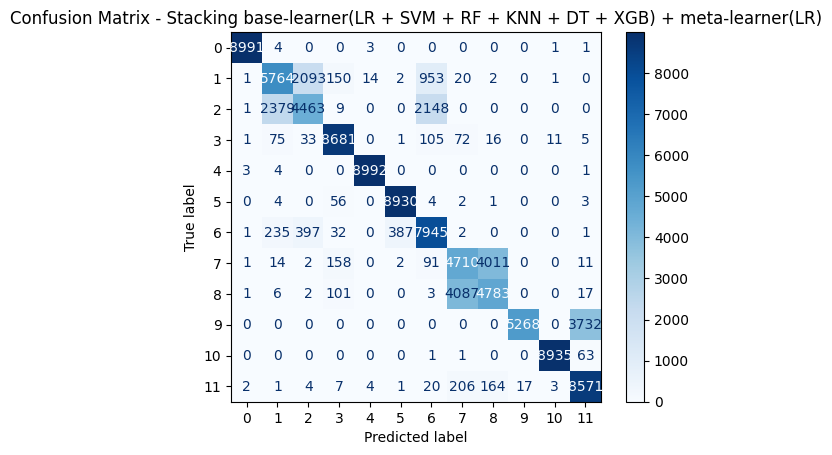

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9000
           1       0.68      0.64      0.66      9000
           2       0.64      0.50      0.56      9000
           3       0.94      0.96      0.95      9000
           4       1.00      1.00      1.00      9000
           5       0.96      0.99      0.97      9000
           6       0.70      0.88      0.78      9000
           7       0.52      0.52      0.52      9000
           8       0.53      0.53      0.53      9000
           9       1.00      0.59      0.74      9000
          10       1.00      0.99      1.00      9000
          11       0.69      0.95      0.80      9000

    accuracy                           0.80    108000
   macro avg       0.80      0.80      0.79    108000
weighted avg       0.80      0.80      0.79    108000



In [36]:
# Definisikan base learner (bisa ditambah jika mau)
start_train = time.time()

base_learners = [
    ("LR", LogisticRegression(max_iter=5000, C= 10, penalty= 'l2', solver= 'newton-cg')),
    ("SVM", SVC(kernel='rbf', C=1, gamma='scale', random_state=42)),
    ("RF", RandomForestClassifier(n_estimators=300, max_depth=20, max_features="log2", min_samples_leaf=4, random_state=42)),
    ("KNN", KNeighborsClassifier(metric= 'minkowski', n_neighbors= 9, p= 1, weights= 'uniform')),
    ("DT", DecisionTreeClassifier(criterion= 'entropy', max_depth= 10, max_features= None, min_samples_leaf= 2, min_samples_split= 2,  random_state=42)),
    ("XGBoost", xgb.XGBClassifier(tree_method="hist", gamma= 0.3, learning_rate= 0.1, max_depth= 5, n_estimators= 300, reg_alpha= 0.01, reg_lambda= 2, random_state=42))
]

# Definisikan meta learner
meta_learner =  LogisticRegression(max_iter=5000, C= 10, penalty= 'l2', solver= 'newton-cg')

# Definisikan Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=3,
    n_jobs=-1,
    passthrough=True,  # kalau True, input fitur asli juga masuk ke meta-learner
    verbose=3
)

# Latih model stacking
stacking_clf.fit(X_train_selected_scaled, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (Stacking base-learner(LR + SVM + RF + KNN + DT + XGB) + meta-learner(XGB)): {training_time:.4f} detik")

# Prediksi dan evaluasi
evaluate_model_2(stacking_clf, X_test_selected_scaled, y_test, name="Stacking base-learner(LR + SVM + RF + KNN + DT + XGB) + meta-learner(LR)")

Waktu pelatihan (Stacking base-learner(LR + SVM + RF + KNN + DT + XGB) + meta-learner(XGB)): 2184.5215 detik
Waktu prediksi (Stacking base-learner(LR + SVM + RF + KNN + DT + XGB) + meta-learner(LR)): 1051.3546 detik
accuracy: 0.7961111111111111
precision: 0.8033545068412492
recall: 0.7961111111111112
f1-score: 0.7924402269463381


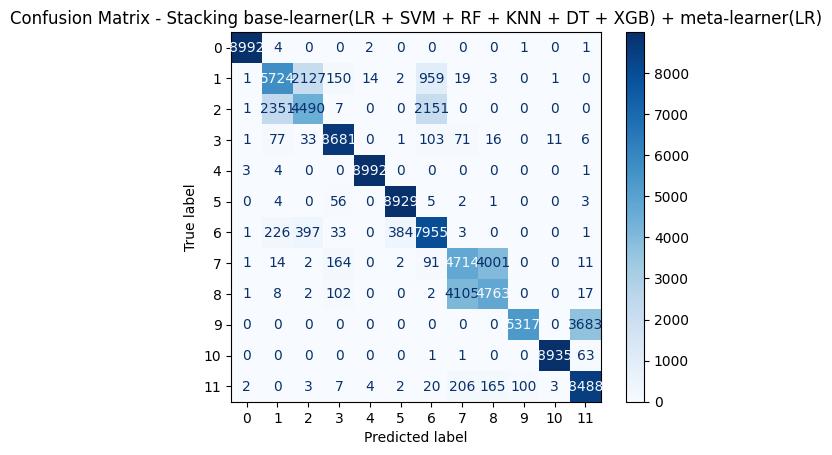

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9000
           1       0.68      0.64      0.66      9000
           2       0.64      0.50      0.56      9000
           3       0.94      0.96      0.95      9000
           4       1.00      1.00      1.00      9000
           5       0.96      0.99      0.97      9000
           6       0.70      0.88      0.78      9000
           7       0.52      0.52      0.52      9000
           8       0.53      0.53      0.53      9000
           9       0.98      0.59      0.74      9000
          10       1.00      0.99      1.00      9000
          11       0.69      0.94      0.80      9000

    accuracy                           0.80    108000
   macro avg       0.80      0.80      0.79    108000
weighted avg       0.80      0.80      0.79    108000



In [37]:
# Definisikan base learner (bisa ditambah jika mau)
start_train = time.time()

base_learners = [
    ("LR", LogisticRegression(max_iter=5000, C= 10, penalty= 'l2', solver= 'newton-cg')),
    ("SVM", SVC(kernel='rbf', C=1, gamma='scale', random_state=42)),
    ("RF", RandomForestClassifier(n_estimators=300, max_depth=20, max_features="log2", min_samples_leaf=4, random_state=42)),
    ("KNN", KNeighborsClassifier(metric= 'minkowski', n_neighbors= 9, p= 1, weights= 'uniform')),
    ("DT", DecisionTreeClassifier(criterion= 'entropy', max_depth= 10, max_features= None, min_samples_leaf= 2, min_samples_split= 2,  random_state=42)),
    ("XGBoost", xgb.XGBClassifier(tree_method="hist", gamma= 0.3, learning_rate= 0.1, max_depth= 5, n_estimators= 300, reg_alpha= 0.01, reg_lambda= 2, random_state=42))
]

# Definisikan meta learner
meta_learner =  LogisticRegression(max_iter=5000, C= 10, penalty= 'l2', solver= 'newton-cg')

# Definisikan Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=3,
    n_jobs=-1,
    passthrough=False,  # kalau True, input fitur asli juga masuk ke meta-learner
    verbose=3
)

# Latih model stacking
stacking_clf.fit(X_train_selected_scaled, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (Stacking base-learner(LR + SVM + RF + KNN + DT + XGB) + meta-learner(XGB)): {training_time:.4f} detik")

# Prediksi dan evaluasi
evaluate_model_2(stacking_clf, X_test_selected_scaled, y_test, name="Stacking base-learner(LR + SVM + RF + KNN + DT + XGB) + meta-learner(LR)")

##### LR, SVM, RF, KNN, DT, XGBoost	-> XGB (based on Paper 1)

In [ ]:
# Definisikan base learner (bisa ditambah jika mau)
start_train = time.time()

base_learners = [
    ("LR", LogisticRegression(max_iter=5000, C= 10, penalty= 'l2', solver= 'newton-cg')),
    ("SVM", SVC(kernel='rbf', C=1, gamma='scale', random_state=42)),
    ("RF", RandomForestClassifier(n_estimators=300, max_depth=20, max_features="log2", min_samples_leaf=4, random_state=42)),
    ("KNN", KNeighborsClassifier(metric= 'minkowski', n_neighbors= 9, p= 1, weights= 'uniform')),
    ("DT", DecisionTreeClassifier(criterion= 'entropy', max_depth= 10, max_features= None, min_samples_leaf= 2, min_samples_split= 2,  random_state=42)),
    ("XGBoost", xgb.XGBClassifier(tree_method="hist", gamma= 0.3, learning_rate= 0.1, max_depth= 5, n_estimators= 300, reg_alpha= 0.01, reg_lambda= 2, random_state=42))
]

# Definisikan meta learner
meta_learner =  xgb.XGBClassifier(tree_method="hist", gamma= 0.3, learning_rate= 0.1, max_depth= 5, n_estimators= 300, reg_alpha= 0.01, reg_lambda= 2, random_state=42)

# Definisikan Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=3,
    n_jobs=-1,
    passthrough=True,  # kalau True, input fitur asli juga masuk ke meta-learner
    verbose=3
)

# Latih model stacking
stacking_clf.fit(X_train_selected_scaled, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (Stacking base-learner(LR + SVM + RF + KNN + DT + XGB) + meta-learner(XGB)): {training_time:.4f} detik")

# Prediksi dan evaluasi
evaluate_model_2(stacking_clf, X_test_selected_scaled, y_test, name="Stacking base-learner(LR + SVM + RF + KNN + DT + XGB) + meta-learner(XGB)")

In [ ]:
# Definisikan base learner (bisa ditambah jika mau)
start_train = time.time()

base_learners = [
    ("LR", LogisticRegression(max_iter=5000, C= 10, penalty= 'l2', solver= 'newton-cg')),
    ("SVM", SVC(kernel='rbf', C=1, gamma='scale', random_state=42)),
    ("RF", RandomForestClassifier(n_estimators=300, max_depth=20, max_features="log2", min_samples_leaf=4, random_state=42)),
    ("KNN", KNeighborsClassifier(metric= 'minkowski', n_neighbors= 9, p= 1, weights= 'uniform')),
    ("DT", DecisionTreeClassifier(criterion= 'entropy', max_depth= 10, max_features= None, min_samples_leaf= 2, min_samples_split= 2,  random_state=42)),
    ("XGBoost", xgb.XGBClassifier(tree_method="hist", gamma= 0.3, learning_rate= 0.1, max_depth= 5, n_estimators= 300, reg_alpha= 0.01, reg_lambda= 2, random_state=42))
]

# Definisikan meta learner
meta_learner =  xgb.XGBClassifier(tree_method="hist", gamma= 0.3, learning_rate= 0.1, max_depth= 5, n_estimators= 300, reg_alpha= 0.01, reg_lambda= 2, random_state=42)

# Definisikan Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=3,
    n_jobs=-1,
    passthrough=False,  # kalau True, input fitur asli juga masuk ke meta-learner
    verbose=3
)

# Latih model stacking
stacking_clf.fit(X_train_selected_scaled, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (Stacking base-learner(LR + SVM + RF + KNN + DT + XGB) + meta-learner(XGB)): {training_time:.4f} detik")

# Prediksi dan evaluasi
evaluate_model_2(stacking_clf, X_test_selected_scaled, y_test, name="Stacking base-learner(LR + SVM + RF + KNN + DT + XGB) + meta-learner(XGB)")

##### Stacking

Waktu pelatihan (Stacking XGB + RF + SVM + LR): 2253.1725 detik
Waktu prediksi (Stacking XGB + RF + SVM + LR): 1068.4576 detik
accuracy: 0.7951666666666667
precision: 0.8014822867384291
recall: 0.7951666666666668
f1-score: 0.7915899057584993


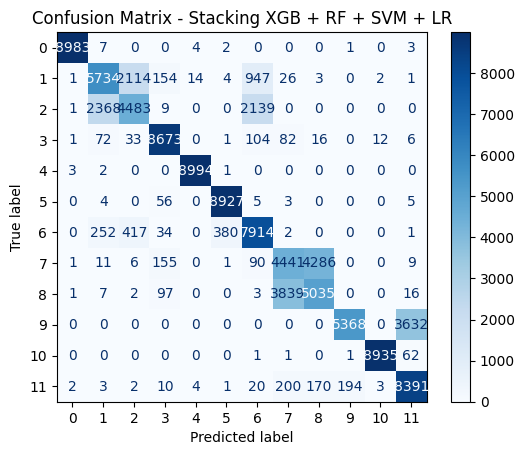

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9000
           1       0.68      0.64      0.66      9000
           2       0.64      0.50      0.56      9000
           3       0.94      0.96      0.95      9000
           4       1.00      1.00      1.00      9000
           5       0.96      0.99      0.97      9000
           6       0.71      0.88      0.78      9000
           7       0.52      0.49      0.50      9000
           8       0.53      0.56      0.54      9000
           9       0.96      0.60      0.74      9000
          10       1.00      0.99      1.00      9000
          11       0.69      0.93      0.79      9000

    accuracy                           0.80    108000
   macro avg       0.80      0.80      0.79    108000
weighted avg       0.80      0.80      0.79    108000



In [21]:
# Definisikan base learner (bisa ditambah jika mau)
start_train = time.time()

base_learners = [
    ("XGB", xgb.XGBClassifier(tree_method="hist", n_estimator=300,gamma=0.3, learning_rate=0.1, max_depth=5, reg_alpha=0.01, reg_lambda=2, random_state=42)),
    ("RandomForest", RandomForestClassifier(n_estimators=300, max_depth=20, max_features="log2", min_samples_leaf=4, random_state=42)),
    ("SVM", SVC(kernel='rbf', C=10, gamma='scale', random_state=42))
]

# Definisikan meta learner
meta_learner = LogisticRegression(max_iter=5000, C= 10, penalty= 'l2', solver= 'newton-cg')

# Definisikan Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=3,
    n_jobs=-1,
    passthrough=True,  # kalau True, input fitur asli juga masuk ke meta-learner
    verbose=3
)

# Latih model stacking
stacking_clf.fit(X_train_selected_scaled, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (Stacking XGB + RF + SVM + LR): {training_time:.4f} detik")

# Prediksi dan evaluasi
evaluate_model_2(stacking_clf, X_test_selected_scaled, y_test, name="Stacking XGB + RF + SVM + LR")


Waktu pelatihan (Stacking DT + SVM + LR + XGB): 1721.5110 detik
Waktu prediksi (Stacking DT + SVM + LR + XGB): 1018.6590 detik
accuracy: 0.7930925925925926
precision: 0.8005749200204589
recall: 0.7930925925925926
f1-score: 0.7880178759882547


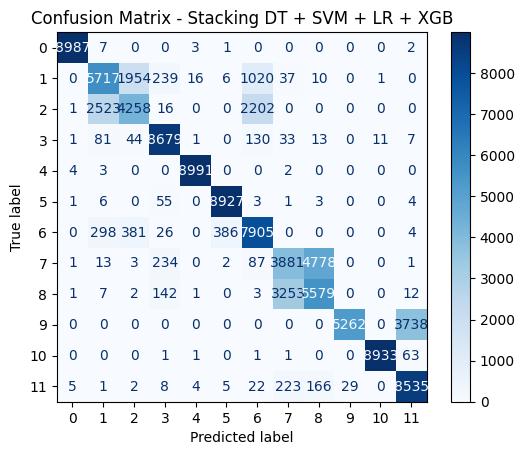

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9000
           1       0.66      0.64      0.65      9000
           2       0.64      0.47      0.54      9000
           3       0.92      0.96      0.94      9000
           4       1.00      1.00      1.00      9000
           5       0.96      0.99      0.97      9000
           6       0.70      0.88      0.78      9000
           7       0.52      0.43      0.47      9000
           8       0.53      0.62      0.57      9000
           9       0.99      0.58      0.74      9000
          10       1.00      0.99      1.00      9000
          11       0.69      0.95      0.80      9000

    accuracy                           0.79    108000
   macro avg       0.80      0.79      0.79    108000
weighted avg       0.80      0.79      0.79    108000



In [20]:
# Definisikan base learner (bisa ditambah jika mau)
start_train = time.time()

base_learners = [
    ("Decision Tree", DecisionTreeClassifier(criterion= 'entropy', max_depth= 10, max_features= None, min_samples_leaf= 2, min_samples_split= 2,  random_state=42)),
    ("SVM", SVC(kernel='rbf', C=10, gamma='scale', random_state=42)),
    ("LR", LogisticRegression(max_iter=5000, C= 10, penalty= 'l2', solver= 'newton-cg'))
]

# Definisikan meta learner
meta_learner = xgb.XGBClassifier(tree_method="hist", gamma=0.3, learning_rate=0.1, max_depth=5, reg_alpha=0.01, reg_lambda=2, random_state=42)

# Definisikan Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=3,
    n_jobs=-1,
    passthrough=True,  # kalau True, input fitur asli juga masuk ke meta-learner
    verbose=3
)

# Latih model stacking
stacking_clf.fit(X_train_selected_scaled, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (Stacking DT + SVM + LR + XGB): {training_time:.4f} detik")

# Prediksi dan evaluasi
evaluate_model_2(stacking_clf, X_test_selected_scaled, y_test, name="Stacking DT + SVM + LR + XGB")


Waktu pelatihan (Stacking XGB + RF + KNN + LR): 344.2900 detik
Waktu prediksi (Stacking XGB + RF + KNN + LR): 18.8641 detik
accuracy: 0.7951388888888888
precision: 0.8011834187706451
recall: 0.7951388888888888
f1-score: 0.7917722169845448


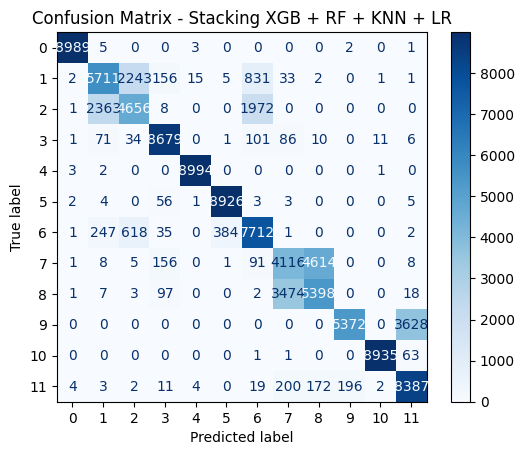

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9000
           1       0.68      0.63      0.66      9000
           2       0.62      0.52      0.56      9000
           3       0.94      0.96      0.95      9000
           4       1.00      1.00      1.00      9000
           5       0.96      0.99      0.97      9000
           6       0.72      0.86      0.78      9000
           7       0.52      0.46      0.49      9000
           8       0.53      0.60      0.56      9000
           9       0.96      0.60      0.74      9000
          10       1.00      0.99      1.00      9000
          11       0.69      0.93      0.79      9000

    accuracy                           0.80    108000
   macro avg       0.80      0.80      0.79    108000
weighted avg       0.80      0.80      0.79    108000



In [ ]:
# Definisikan base learner (bisa ditambah jika mau)
start_train = time.time()

base_learners = [
    ("XGB", xgb.XGBClassifier(tree_method="hist", n_estimator=300,gamma=0.3, learning_rate=0.1, max_depth=5, reg_alpha=0.01, reg_lambda=2, random_state=42)),
    ("RandomForest", RandomForestClassifier(n_estimators=300, max_depth=20, max_features="log2", min_samples_leaf=4, random_state=42)),
    ("KNN", KNeighborsClassifier(n_neighbors=17))
]

# Definisikan meta learner
meta_learner = LogisticRegression(max_iter=5000, C= 10, penalty= 'l2', solver= 'newton-cg')

# Definisikan Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=3,
    n_jobs=-1,
    passthrough=True,  # kalau True, input fitur asli juga masuk ke meta-learner
    verbose=3
)

# Latih model stacking
stacking_clf.fit(X_train_selected_scaled, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan ( ): {training_time:.4f} detik")

# Prediksi dan evaluasi
evaluate_model_2(stacking_clf, X_test_selected_scaled, y_test, name="Stacking XGB + RF + KNN + LR")


#### Algoritma Individual

##### LogReg

Waktu pelatihan (Logistic Regression): 239.3741 detik
Waktu prediksi (Logistic Regression): 0.0141 detik


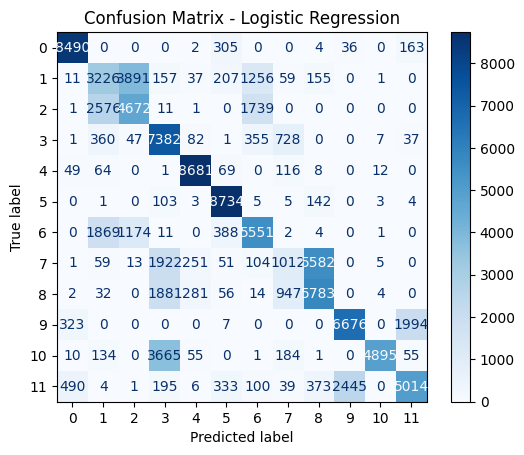

              precision    recall  f1-score   support

           0       0.91      0.94      0.92      9000
           1       0.39      0.36      0.37      9000
           2       0.48      0.52      0.50      9000
           3       0.48      0.82      0.61      9000
           4       0.92      0.96      0.94      9000
           5       0.86      0.97      0.91      9000
           6       0.61      0.62      0.61      9000
           7       0.33      0.11      0.17      9000
           8       0.48      0.64      0.55      9000
           9       0.73      0.74      0.74      9000
          10       0.99      0.54      0.70      9000
          11       0.69      0.56      0.62      9000

    accuracy                           0.65    108000
   macro avg       0.66      0.65      0.64    108000
weighted avg       0.66      0.65      0.64    108000



In [18]:
# Logistic Regression
start_train = time.time()

logreg = LogisticRegression(max_iter=5000, C= 10, penalty= 'l2', solver= 'newton-cg')
logreg.fit(X_train_selected_scaled, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (Logistic Regression): {training_time:.4f} detik")

evaluate_model(logreg, X_test_selected_scaled, y_test, name="Logistic Regression")

Waktu pelatihan (Logistic Regression): 59.3822 detik
Waktu prediksi (Logistic Regression): 0.0100 detik


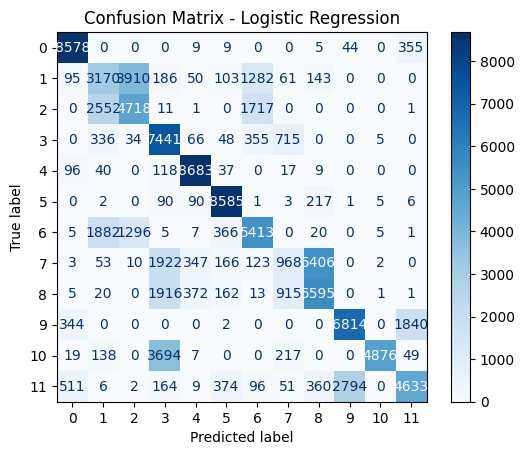

              precision    recall  f1-score   support

           0       0.89      0.95      0.92      9000
           1       0.39      0.35      0.37      9000
           2       0.47      0.52      0.50      9000
           3       0.48      0.83      0.61      9000
           4       0.90      0.96      0.93      9000
           5       0.87      0.95      0.91      9000
           6       0.60      0.60      0.60      9000
           7       0.33      0.11      0.16      9000
           8       0.48      0.62      0.54      9000
           9       0.71      0.76      0.73      9000
          10       1.00      0.54      0.70      9000
          11       0.67      0.51      0.58      9000

    accuracy                           0.64    108000
   macro avg       0.65      0.64      0.63    108000
weighted avg       0.65      0.64      0.63    108000



In [27]:
# Logistic Regression
start_train = time.time()

logreg = LogisticRegression(max_iter=1000, solver='lbfgs')
logreg.fit(X_train_selected_scaled, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (Logistic Regression): {training_time:.4f} detik")

evaluate_model(logreg, X_test_selected_scaled, y_test, name="Logistic Regression")

##### Adaboost

Waktu pelatihan (AdaBoost): 78.8794 detik
Waktu prediksi (AdaBoost): 4.3311 detik
accuracy: 0.6638240740740741
precision: 0.6908083404927096
recall: 0.6638240740740741
f1-score: 0.6315335843426377


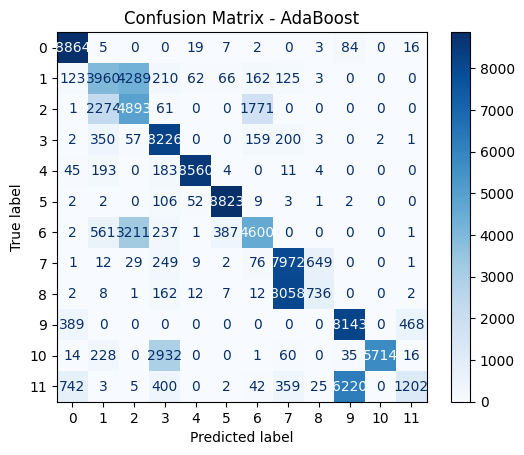

              precision    recall  f1-score   support

           0       0.87      0.98      0.92      9000
           1       0.52      0.44      0.48      9000
           2       0.39      0.54      0.46      9000
           3       0.64      0.91      0.76      9000
           4       0.98      0.95      0.97      9000
           5       0.95      0.98      0.96      9000
           6       0.67      0.51      0.58      9000
           7       0.47      0.89      0.62      9000
           8       0.52      0.08      0.14      9000
           9       0.56      0.90      0.69      9000
          10       1.00      0.63      0.78      9000
          11       0.70      0.13      0.22      9000

    accuracy                           0.66    108000
   macro avg       0.69      0.66      0.63    108000
weighted avg       0.69      0.66      0.63    108000



In [47]:
# AdaBoost
start_train = time.time()

adc = AdaBoostClassifier(learning_rate= 1, n_estimators= 300)
adc.fit(X_train_selected_scaled, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (AdaBoost): {training_time:.4f} detik")

evaluate_model_2(adc, X_test_selected_scaled, y_test, name="AdaBoost")

Waktu pelatihan (AdaBoost): 15.9617 detik
Waktu prediksi (AdaBoost Classifier): 0.9046 detik


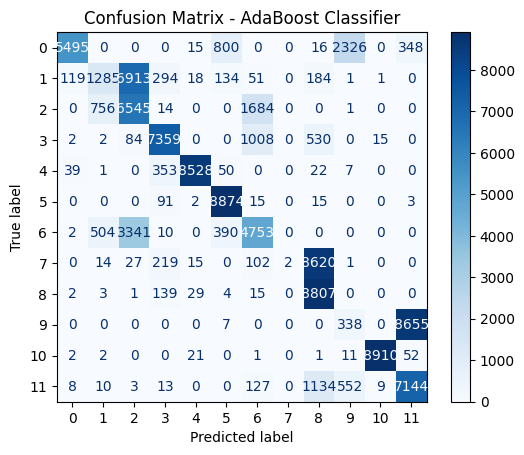

              precision    recall  f1-score   support

           0       0.97      0.61      0.75      9000
           1       0.50      0.14      0.22      9000
           2       0.39      0.73      0.51      9000
           3       0.87      0.82      0.84      9000
           4       0.99      0.95      0.97      9000
           5       0.86      0.99      0.92      9000
           6       0.61      0.53      0.57      9000
           7       1.00      0.00      0.00      9000
           8       0.46      0.98      0.62      9000
           9       0.10      0.04      0.06      9000
          10       1.00      0.99      0.99      9000
          11       0.44      0.79      0.57      9000

    accuracy                           0.63    108000
   macro avg       0.68      0.63      0.58    108000
weighted avg       0.68      0.63      0.58    108000



In [19]:
# AdaBoost
start_train = time.time()

adc = AdaBoostClassifier(random_state=42)
adc.fit(X_train_selected_scaled, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (AdaBoost): {training_time:.4f} detik")

evaluate_model(adc, X_test_selected_scaled, y_test, name="AdaBoost Classifier")

##### kNN

Waktu pelatihan (KNN): 0.0280 detik
Waktu prediksi (KNN): 44.9229 detik
accuracy: 0.7672314814814815
precision: 0.7670544385270138
recall: 0.7672314814814815
f1-score: 0.7663477555519301


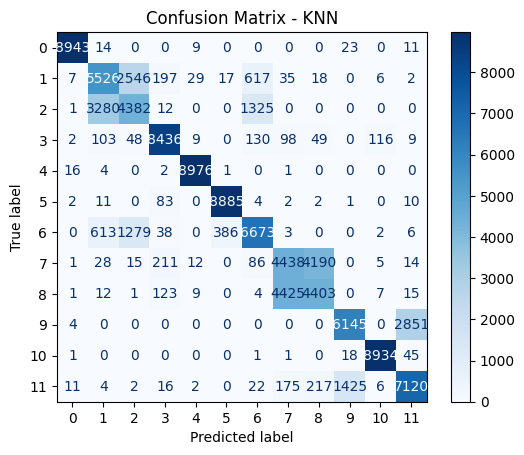

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      9000
           1       0.58      0.61      0.59      9000
           2       0.53      0.49      0.51      9000
           3       0.93      0.94      0.93      9000
           4       0.99      1.00      0.99      9000
           5       0.96      0.99      0.97      9000
           6       0.75      0.74      0.75      9000
           7       0.48      0.49      0.49      9000
           8       0.50      0.49      0.49      9000
           9       0.81      0.68      0.74      9000
          10       0.98      0.99      0.99      9000
          11       0.71      0.79      0.75      9000

    accuracy                           0.77    108000
   macro avg       0.77      0.77      0.77    108000
weighted avg       0.77      0.77      0.77    108000



In [30]:
# KNN
start_train = time.time()

knn = KNeighborsClassifier(metric= 'minkowski', n_neighbors= 9, p= 1, weights= 'uniform')
knn.fit(X_train_selected_scaled, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (KNN): {training_time:.4f} detik")

evaluate_model_2(knn, X_test_selected_scaled, y_test, name="KNN")

Waktu pelatihan (KNN): 0.0270 detik
Waktu prediksi (KNN): 16.0842 detik
accuracy: 0.7643240740740741
precision: 0.7645137576269203
recall: 0.7643240740740741
f1-score: 0.7627184808259743


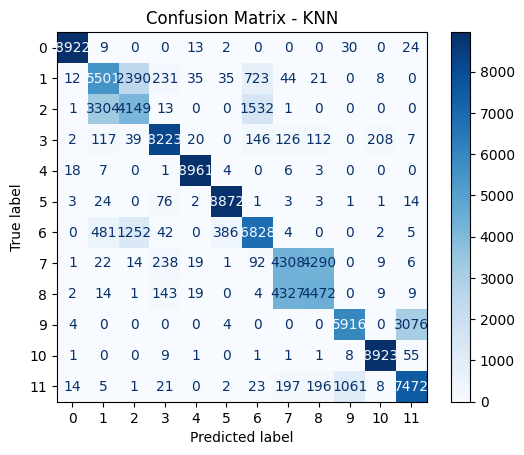

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      9000
           1       0.58      0.61      0.60      9000
           2       0.53      0.46      0.49      9000
           3       0.91      0.91      0.91      9000
           4       0.99      1.00      0.99      9000
           5       0.95      0.99      0.97      9000
           6       0.73      0.76      0.74      9000
           7       0.48      0.48      0.48      9000
           8       0.49      0.50      0.49      9000
           9       0.84      0.66      0.74      9000
          10       0.97      0.99      0.98      9000
          11       0.70      0.83      0.76      9000

    accuracy                           0.76    108000
   macro avg       0.76      0.76      0.76    108000
weighted avg       0.76      0.76      0.76    108000



In [31]:
# KNN
start_train = time.time()

knn = KNeighborsClassifier(n_neighbors=17)
knn.fit(X_train_selected_scaled, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (KNN): {training_time:.4f} detik")

evaluate_model_2(knn, X_test_selected_scaled, y_test, name="KNN")

Waktu pelatihan (KNN): 0.0707 detik
Waktu prediksi (KNN): 16.3393 detik


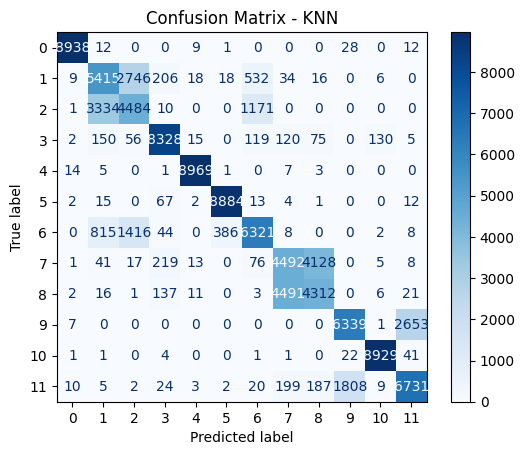

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      9000
           1       0.55      0.60      0.58      9000
           2       0.51      0.50      0.51      9000
           3       0.92      0.93      0.92      9000
           4       0.99      1.00      0.99      9000
           5       0.96      0.99      0.97      9000
           6       0.77      0.70      0.73      9000
           7       0.48      0.50      0.49      9000
           8       0.49      0.48      0.49      9000
           9       0.77      0.70      0.74      9000
          10       0.98      0.99      0.99      9000
          11       0.71      0.75      0.73      9000

    accuracy                           0.76    108000
   macro avg       0.76      0.76      0.76    108000
weighted avg       0.76      0.76      0.76    108000



In [30]:
# KNN
start_train = time.time()

knn = KNeighborsClassifier()
knn.fit(X_train_selected_scaled, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (KNN): {training_time:.4f} detik")

evaluate_model(knn, X_test_selected_scaled, y_test, name="KNN")

##### XGBoost

Waktu pelatihan (XGBoost): 16.9916 detik
Waktu prediksi (XGBoost): 0.3716 detik
accuracy: 0.7928611111111111
precision: 0.799683963490848
recall: 0.7928611111111111
f1-score: 0.7891777309637759


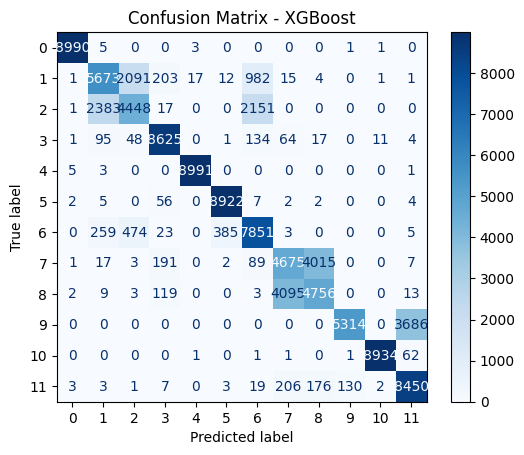

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9000
           1       0.67      0.63      0.65      9000
           2       0.63      0.49      0.55      9000
           3       0.93      0.96      0.95      9000
           4       1.00      1.00      1.00      9000
           5       0.96      0.99      0.97      9000
           6       0.70      0.87      0.78      9000
           7       0.52      0.52      0.52      9000
           8       0.53      0.53      0.53      9000
           9       0.98      0.59      0.74      9000
          10       1.00      0.99      1.00      9000
          11       0.69      0.94      0.80      9000

    accuracy                           0.79    108000
   macro avg       0.80      0.79      0.79    108000
weighted avg       0.80      0.79      0.79    108000



In [42]:
# XGBoost
start_train = time.time()

xgBoost = xgb.XGBClassifier(tree_method="hist", n_estimators=500, gamma=0.3, learning_rate=0.1, max_depth=10, reg_alpha=0.01, reg_lambda=2, random_state=42)
xgBoost.fit(X_train_selected_scaled, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (XGBoost): {training_time:.4f} detik")

evaluate_model_2(xgBoost, X_test_selected_scaled, y_test, name="XGBoost")

Waktu pelatihan (XGBoost): 13.6740 detik
Waktu prediksi (XGBoost): 0.3119 detik
accuracy: 0.7942685185185185
precision: 0.8009756678002189
recall: 0.7942685185185184
f1-score: 0.7903031002163466


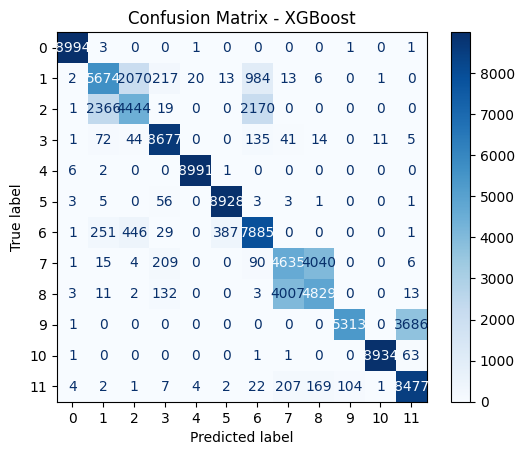

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9000
           1       0.68      0.63      0.65      9000
           2       0.63      0.49      0.56      9000
           3       0.93      0.96      0.95      9000
           4       1.00      1.00      1.00      9000
           5       0.96      0.99      0.97      9000
           6       0.70      0.88      0.78      9000
           7       0.52      0.52      0.52      9000
           8       0.53      0.54      0.53      9000
           9       0.98      0.59      0.74      9000
          10       1.00      0.99      1.00      9000
          11       0.69      0.94      0.80      9000

    accuracy                           0.79    108000
   macro avg       0.80      0.79      0.79    108000
weighted avg       0.80      0.79      0.79    108000



In [38]:
# XGBoost
start_train = time.time()

xgBoost = xgb.XGBClassifier(tree_method="hist", n_estimators=300,gamma=0.3, learning_rate=0.1, max_depth=5, reg_alpha=0.01, reg_lambda=2, random_state=42)
xgBoost.fit(X_train_selected_scaled, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (XGBoost): {training_time:.4f} detik")

evaluate_model_2(xgBoost, X_test_selected_scaled, y_test, name="XGBoost")

Waktu pelatihan (XGBoost): 6.3491 detik
Waktu prediksi (XGBoost): 0.1950 detik


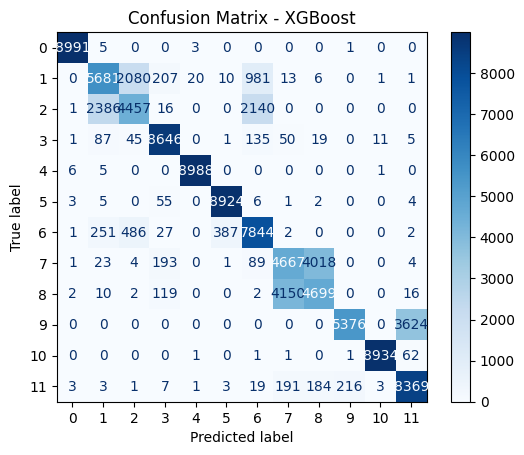

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9000
           1       0.67      0.63      0.65      9000
           2       0.63      0.50      0.55      9000
           3       0.93      0.96      0.95      9000
           4       1.00      1.00      1.00      9000
           5       0.96      0.99      0.97      9000
           6       0.70      0.87      0.78      9000
           7       0.51      0.52      0.52      9000
           8       0.53      0.52      0.52      9000
           9       0.96      0.60      0.74      9000
          10       1.00      0.99      1.00      9000
          11       0.69      0.93      0.79      9000

    accuracy                           0.79    108000
   macro avg       0.80      0.79      0.79    108000
weighted avg       0.80      0.79      0.79    108000



In [22]:
# XGBoost
start_train = time.time()

xgBoost = xgb.XGBClassifier(tree_method="hist")
xgBoost.fit(X_train_selected_scaled, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (XGBoost): {training_time:.4f} detik")

evaluate_model(xgBoost, X_test_selected_scaled, y_test, name="XGBoost")

##### DT

Waktu pelatihan (Decision Tree): 2.0417 detik
Waktu prediksi (Decision Tree): 0.0155 detik


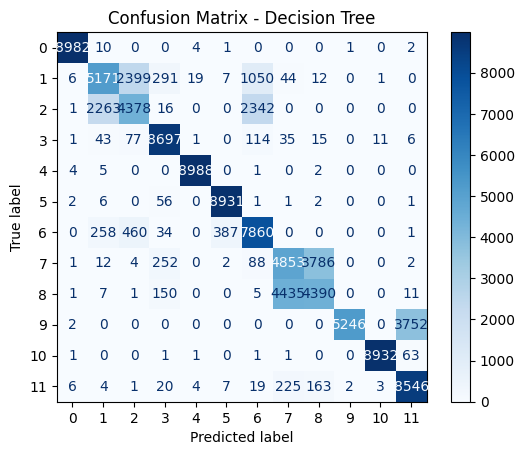

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9000
           1       0.66      0.57      0.62      9000
           2       0.60      0.49      0.54      9000
           3       0.91      0.97      0.94      9000
           4       1.00      1.00      1.00      9000
           5       0.96      0.99      0.97      9000
           6       0.68      0.87      0.77      9000
           7       0.51      0.54      0.52      9000
           8       0.52      0.49      0.51      9000
           9       1.00      0.58      0.74      9000
          10       1.00      0.99      1.00      9000
          11       0.69      0.95      0.80      9000

    accuracy                           0.79    108000
   macro avg       0.79      0.79      0.78    108000
weighted avg       0.79      0.79      0.78    108000



In [19]:
# Decision Tree
start_train = time.time()

dt = DecisionTreeClassifier(criterion= 'entropy', max_depth= 10, max_features= None, min_samples_leaf= 2, min_samples_split= 2, random_state=42)
dt.fit(X_train_selected_scaled, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (Decision Tree): {training_time:.4f} detik")

evaluate_model(dt, X_test_selected_scaled, y_test, name="Decision Tree")

Waktu pelatihan (Decision Tree): 3.2314 detik
Waktu prediksi (Decision Tree): 0.0506 detik


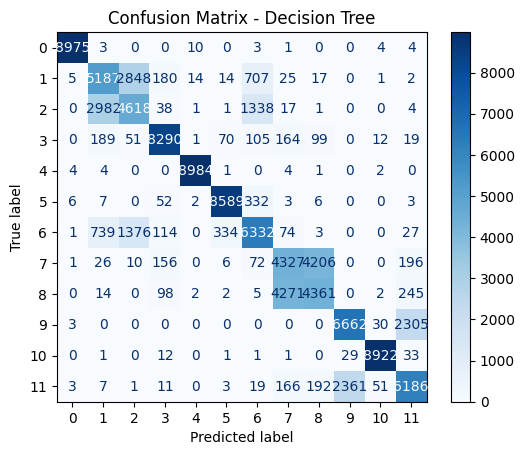

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9000
           1       0.57      0.58      0.57      9000
           2       0.52      0.51      0.52      9000
           3       0.93      0.92      0.92      9000
           4       1.00      1.00      1.00      9000
           5       0.95      0.95      0.95      9000
           6       0.71      0.70      0.71      9000
           7       0.48      0.48      0.48      9000
           8       0.49      0.48      0.49      9000
           9       0.74      0.74      0.74      9000
          10       0.99      0.99      0.99      9000
          11       0.69      0.69      0.69      9000

    accuracy                           0.75    108000
   macro avg       0.75      0.75      0.75    108000
weighted avg       0.75      0.75      0.75    108000



In [24]:
# Decision Tree
start_train = time.time()

dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_selected_scaled, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (Decision Tree): {training_time:.4f} detik")

evaluate_model(dt, X_test_selected_scaled, y_test, name="Decision Tree")

##### RandomForest

Waktu pelatihan (Random Forest): 99.5294 detik
Waktu prediksi (Random Forest): 4.9564 detik
accuracy: 0.7933148148148148
precision: 0.8005706254864003
recall: 0.7933148148148149
f1-score: 0.7890975214865904


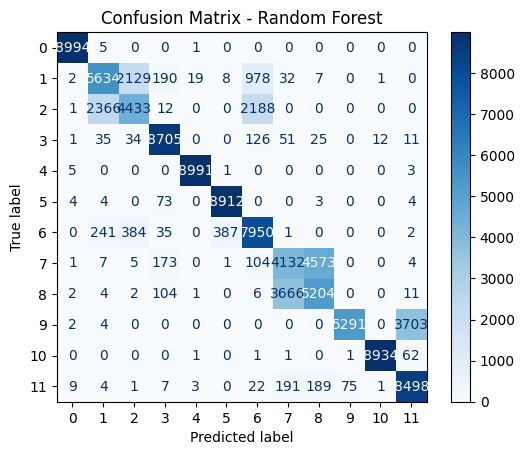

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9000
           1       0.68      0.63      0.65      9000
           2       0.63      0.49      0.55      9000
           3       0.94      0.97      0.95      9000
           4       1.00      1.00      1.00      9000
           5       0.96      0.99      0.97      9000
           6       0.70      0.88      0.78      9000
           7       0.51      0.46      0.48      9000
           8       0.52      0.58      0.55      9000
           9       0.99      0.59      0.74      9000
          10       1.00      0.99      1.00      9000
          11       0.69      0.94      0.80      9000

    accuracy                           0.79    108000
   macro avg       0.80      0.79      0.79    108000
weighted avg       0.80      0.79      0.79    108000



In [46]:
# Random Forest
start_train = time.time()

rf = RandomForestClassifier(n_estimators=300, max_depth=20, max_features="log2", min_samples_leaf=4, random_state=42)
rf.fit(X_train_selected_scaled, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (Random Forest): {training_time:.4f} detik")

evaluate_model_2(rf, X_test_selected_scaled, y_test, name="Random Forest")

Waktu pelatihan (Random Forest): 57.2856 detik
Waktu prediksi (Random Forest): 2.4385 detik


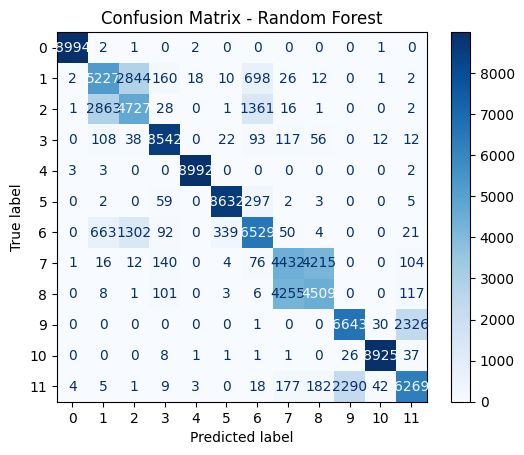

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9000
           1       0.59      0.58      0.58      9000
           2       0.53      0.53      0.53      9000
           3       0.93      0.95      0.94      9000
           4       1.00      1.00      1.00      9000
           5       0.96      0.96      0.96      9000
           6       0.72      0.73      0.72      9000
           7       0.49      0.49      0.49      9000
           8       0.50      0.50      0.50      9000
           9       0.74      0.74      0.74      9000
          10       0.99      0.99      0.99      9000
          11       0.70      0.70      0.70      9000

    accuracy                           0.76    108000
   macro avg       0.76      0.76      0.76    108000
weighted avg       0.76      0.76      0.76    108000



In [23]:
# Random Forest
start_train = time.time()

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_selected_scaled, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (Random Forest): {training_time:.4f} detik")

evaluate_model(rf, X_test_selected_scaled, y_test, name="Random Forest")

##### Naive Bayes

Waktu pelatihan (Naive Bayes): 0.1116 detik
Waktu prediksi (Naive Bayes): 0.2858 detik
accuracy: 0.5019907407407408
precision: 0.5359119936965332
recall: 0.5019907407407408
f1-score: 0.431962283867344


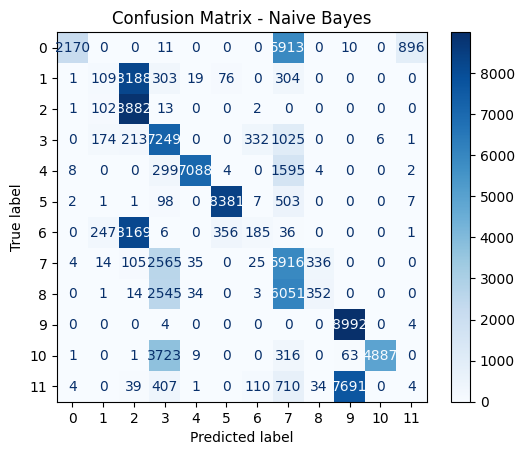

              precision    recall  f1-score   support

           0       0.99      0.24      0.39      9000
           1       0.17      0.01      0.02      9000
           2       0.35      0.99      0.51      9000
           3       0.42      0.81      0.55      9000
           4       0.99      0.79      0.88      9000
           5       0.95      0.93      0.94      9000
           6       0.28      0.02      0.04      9000
           7       0.26      0.66      0.38      9000
           8       0.48      0.04      0.07      9000
           9       0.54      1.00      0.70      9000
          10       1.00      0.54      0.70      9000
          11       0.00      0.00      0.00      9000

    accuracy                           0.50    108000
   macro avg       0.54      0.50      0.43    108000
weighted avg       0.54      0.50      0.43    108000



In [34]:
# Naive Bayes
start_train = time.time()

nb = GaussianNB(var_smoothing= np.float64(1e-06))
nb.fit(X_train_selected_scaled, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (Naive Bayes): {training_time:.4f} detik")

evaluate_model_2(nb, X_test_selected_scaled, y_test, name="Naive Bayes")

Waktu pelatihan (Naive Bayes): 0.1096 detik
Waktu prediksi (Naive Bayes): 0.2211 detik


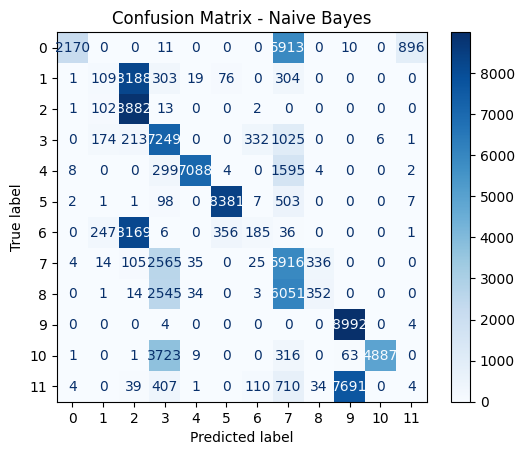

              precision    recall  f1-score   support

           0       0.99      0.24      0.39      9000
           1       0.17      0.01      0.02      9000
           2       0.35      0.99      0.51      9000
           3       0.42      0.81      0.55      9000
           4       0.99      0.79      0.88      9000
           5       0.95      0.93      0.94      9000
           6       0.28      0.02      0.04      9000
           7       0.26      0.66      0.38      9000
           8       0.48      0.04      0.07      9000
           9       0.54      1.00      0.70      9000
          10       1.00      0.54      0.70      9000
          11       0.00      0.00      0.00      9000

    accuracy                           0.50    108000
   macro avg       0.54      0.50      0.43    108000
weighted avg       0.54      0.50      0.43    108000



In [16]:
# Naive Bayes
start_train = time.time()

nb = GaussianNB(var_smoothing= np.float64(1e-06))
nb.fit(X_train_selected_scaled, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (Naive Bayes): {training_time:.4f} detik")

evaluate_model(nb, X_test_selected_scaled, y_test, name="Naive Bayes")

Waktu pelatihan (Naive Bayes): 0.1045 detik
Waktu prediksi (Naive Bayes): 0.2381 detik


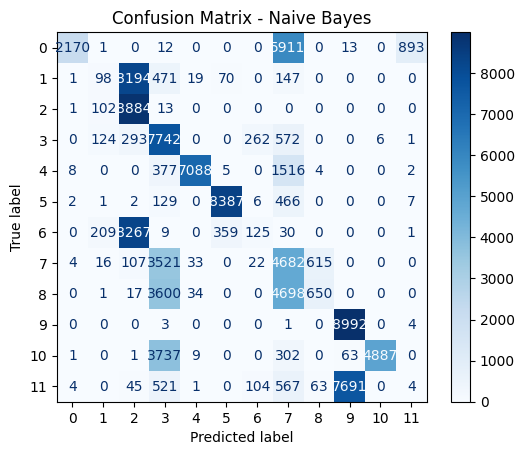

              precision    recall  f1-score   support

           0       0.99      0.24      0.39      9000
           1       0.18      0.01      0.02      9000
           2       0.34      0.99      0.51      9000
           3       0.38      0.86      0.53      9000
           4       0.99      0.79      0.88      9000
           5       0.95      0.93      0.94      9000
           6       0.24      0.01      0.03      9000
           7       0.25      0.52      0.34      9000
           8       0.49      0.07      0.13      9000
           9       0.54      1.00      0.70      9000
          10       1.00      0.54      0.70      9000
          11       0.00      0.00      0.00      9000

    accuracy                           0.50    108000
   macro avg       0.53      0.50      0.43    108000
weighted avg       0.53      0.50      0.43    108000



In [24]:
# Naive Bayes
start_train = time.time()

nb = GaussianNB()
nb.fit(X_train_selected_scaled, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (Naive Bayes): {training_time:.4f} detik")

evaluate_model(nb, X_test_selected_scaled, y_test, name="Naive Bayes")

##### SVM

In [ ]:
# SVM
start_train = time.time()

svm = SVC(kernel='poly', C=10, gamma='scale', random_state=42)
svm.fit(X_train_selected_scaled, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (SVM): {training_time:.4f} detik")

evaluate_model(svm, X_test_selected_scaled, y_test, name="SVM")

Waktu pelatihan (SVM): 543.1396 detik
Waktu prediksi (SVM): 933.4317 detik


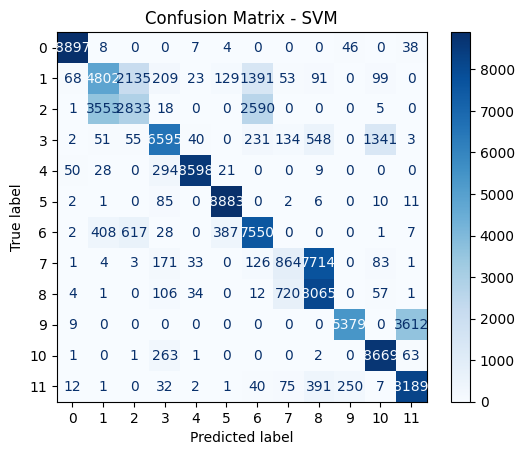

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      9000
           1       0.54      0.53      0.54      9000
           2       0.50      0.31      0.39      9000
           3       0.85      0.73      0.79      9000
           4       0.98      0.96      0.97      9000
           5       0.94      0.99      0.96      9000
           6       0.63      0.84      0.72      9000
           7       0.47      0.10      0.16      9000
           8       0.48      0.90      0.62      9000
           9       0.95      0.60      0.73      9000
          10       0.84      0.96      0.90      9000
          11       0.69      0.91      0.78      9000

    accuracy                           0.73    108000
   macro avg       0.74      0.73      0.71    108000
weighted avg       0.74      0.73      0.71    108000



In [ ]:
# SVM
start_train = time.time()

svm = SVC(kernel='rbf', C=10, gamma='scale', random_state=42)
svm.fit(X_train_selected_scaled, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (SVM): {training_time:.4f} detik")

evaluate_model(svm, X_test_selected_scaled, y_test, name="SVM")

Waktu pelatihan (SVM): 494.3655 detik
Waktu prediksi (SVM): 966.2866 detik


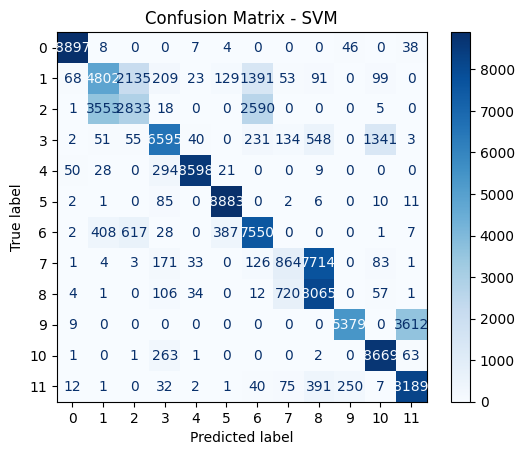

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      9000
           1       0.54      0.53      0.54      9000
           2       0.50      0.31      0.39      9000
           3       0.85      0.73      0.79      9000
           4       0.98      0.96      0.97      9000
           5       0.94      0.99      0.96      9000
           6       0.63      0.84      0.72      9000
           7       0.47      0.10      0.16      9000
           8       0.48      0.90      0.62      9000
           9       0.95      0.60      0.73      9000
          10       0.84      0.96      0.90      9000
          11       0.69      0.91      0.78      9000

    accuracy                           0.73    108000
   macro avg       0.74      0.73      0.71    108000
weighted avg       0.74      0.73      0.71    108000



In [ ]:
# SVM
start_train = time.time()

svm = SVC(kernel='rbf', C=10, gamma='scale', random_state=42)
svm.fit(X_train_selected_scaled, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (SVM): {training_time:.4f} detik")

evaluate_model(svm, X_test_selected_scaled, y_test, name="SVM")

Waktu pelatihan (SVM): 672.1789 detik
Waktu prediksi (SVM): 1023.3660 detik


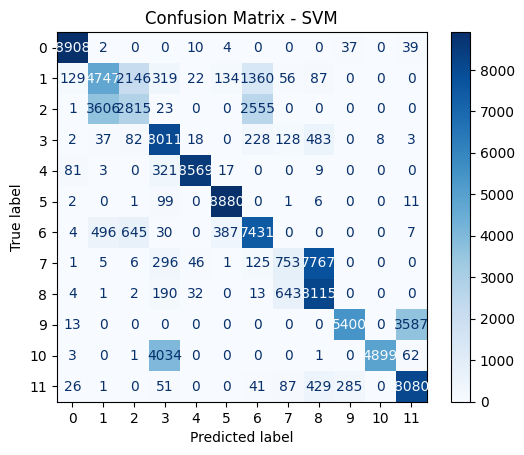

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      9000
           1       0.53      0.53      0.53      9000
           2       0.49      0.31      0.38      9000
           3       0.60      0.89      0.72      9000
           4       0.99      0.95      0.97      9000
           5       0.94      0.99      0.96      9000
           6       0.63      0.83      0.72      9000
           7       0.45      0.08      0.14      9000
           8       0.48      0.90      0.63      9000
           9       0.94      0.60      0.73      9000
          10       1.00      0.54      0.70      9000
          11       0.69      0.90      0.78      9000

    accuracy                           0.71    108000
   macro avg       0.73      0.71      0.69    108000
weighted avg       0.73      0.71      0.69    108000



In [16]:
# SVM
start_train = time.time()

svm = SVC(kernel='rbf', C=1, gamma='scale', random_state=42)
svm.fit(X_train_selected_scaled, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (SVM): {training_time:.4f} detik")

evaluate_model(svm, X_test_selected_scaled, y_test, name="SVM")

Waktu pelatihan (SVM): 608.3027 detik
Waktu prediksi (SVM): 973.3302 detik


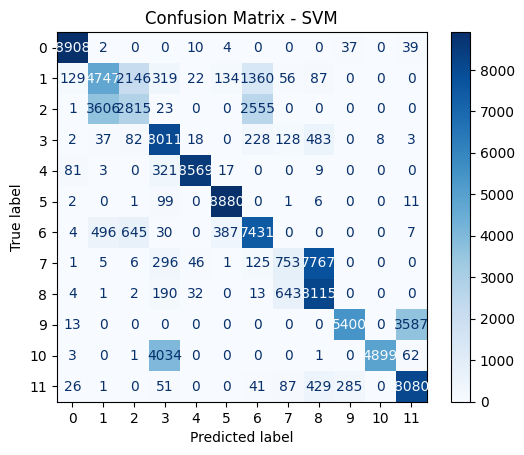

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      9000
           1       0.53      0.53      0.53      9000
           2       0.49      0.31      0.38      9000
           3       0.60      0.89      0.72      9000
           4       0.99      0.95      0.97      9000
           5       0.94      0.99      0.96      9000
           6       0.63      0.83      0.72      9000
           7       0.45      0.08      0.14      9000
           8       0.48      0.90      0.63      9000
           9       0.94      0.60      0.73      9000
          10       1.00      0.54      0.70      9000
          11       0.69      0.90      0.78      9000

    accuracy                           0.71    108000
   macro avg       0.73      0.71      0.69    108000
weighted avg       0.73      0.71      0.69    108000



In [ ]:
# SVM
start_train = time.time()

svm = SVC(kernel='rbf', random_state=42)
svm.fit(X_train_selected_scaled, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (SVM): {training_time:.4f} detik")

evaluate_model(svm, X_test_selected_scaled, y_test, name="SVM")

### Tanpa Classfication Report

In [23]:
import joblib
import glob

#### Stacking

##### Paper 1

In [42]:
base_learners_1 = [
    ("LR", LogisticRegression(max_iter=5000, C= 10, penalty= 'l2', solver= 'newton-cg')),
    ("SVM", SVC(kernel='rbf', C=1, gamma='scale', random_state=42)),
    ("RF", RandomForestClassifier(n_estimators=300, max_depth=20, max_features="log2", min_samples_leaf=4, random_state=42)),
    ("KNN", KNeighborsClassifier(metric= 'minkowski', n_neighbors= 9, p= 1, weights= 'uniform')),
    ("DT", DecisionTreeClassifier(criterion= 'entropy', max_depth= 10, max_features= None, min_samples_leaf= 2, min_samples_split= 2,  random_state=42)),
    ("XGBoost", xgb.XGBClassifier(tree_method="hist", gamma= 0.3, learning_rate= 0.1, max_depth= 5, n_estimators= 300, reg_alpha= 0.01, reg_lambda= 2, random_state=42))
]

# Definisikan meta learner
meta_learner_1 =  xgb.XGBClassifier(tree_method="hist", gamma= 0.3, learning_rate= 0.1, max_depth= 5, n_estimators= 300, reg_alpha= 0.01, reg_lambda= 2, random_state=42)

model_stacking_1 = {
    "stacking_1_true_mi": StackingClassifier(estimators=base_learners_1, final_estimator=meta_learner_1, cv=3, n_jobs=-1, passthrough=True, verbose=3),
    "stacking_1_false_mi": StackingClassifier(estimators=base_learners_1, final_estimator=meta_learner_1, cv=3, n_jobs=-1, passthrough=False, verbose=3)
}

In [44]:
# Loop semua model dan simpan satu per satu
for name, model in model_stacking_1.items():
    model.fit(X_train_selected_scaled, y_train)
    # y_pred = model.predict(X_test_selected_scaled)

    # Save model
    filename = f'{name.replace(" ", "_").lower()}.joblib'
    joblib.dump(model, f'model_training_ensemble_mi/{filename}')
    
    # Save hasil predict_proba
    # np.save(f'model_training_ensemble_mi/y_pred_{name.replace(" ", "_").lower()}.npy', y_pred)
    
    print(f'Model dan hasil prediksi {name} berhasil disimpan.')

Model dan hasil prediksi stacking_1_true_mi berhasil disimpan.
Model dan hasil prediksi stacking_1_false_mi berhasil disimpan.


##### Paper 2

In [45]:
base_learners_2 = [
    ("LR", LogisticRegression(max_iter=5000, C= 10, penalty= 'l2', solver= 'newton-cg')),
    ("SVM", SVC(kernel='rbf', C=1, gamma='scale', random_state=42)),
    ("RF", RandomForestClassifier(n_estimators=300, max_depth=20, max_features="log2", min_samples_leaf=4, random_state=42)),
    ("KNN", KNeighborsClassifier(metric= 'minkowski', n_neighbors= 9, p= 1, weights= 'uniform')),
    ("DT", DecisionTreeClassifier(criterion= 'entropy', max_depth= 10, max_features= None, min_samples_leaf= 2, min_samples_split= 2,  random_state=42)),
    ("XGBoost", xgb.XGBClassifier(tree_method="hist", gamma= 0.3, learning_rate= 0.1, max_depth= 5, n_estimators= 300, reg_alpha= 0.01, reg_lambda= 2, random_state=42))
]

# Definisikan meta learner
meta_learner_2 = LogisticRegression(max_iter=5000, C= 10, penalty= 'l2', solver= 'newton-cg')

model_stacking_2 = {
    "stacking_2_true_mi": StackingClassifier(estimators=base_learners_2, final_estimator=meta_learner_2, cv=3, n_jobs=-1, passthrough=True, verbose=3),
    "stacking_2_false_mi": StackingClassifier(estimators=base_learners_2, final_estimator=meta_learner_2, cv=3, n_jobs=-1, passthrough=False, verbose=3)
}

In [46]:
# Loop semua model dan simpan satu per satu
for name, model in model_stacking_2.items():
    model.fit(X_train_selected_scaled, y_train)
    # y_pred = model.predict(X_test_selected_scaled)

    # Save model
    filename = f'{name.replace(" ", "_").lower()}.joblib'
    joblib.dump(model, f'model_training_ensemble_mi/{filename}')
    
    # Save hasil predict_proba
    # np.save(f'model_training_ensemble_mi/y_pred_{name.replace(" ", "_").lower()}.npy', y_pred)
    
    print(f'Model dan hasil prediksi {name} berhasil disimpan.')

Model dan hasil prediksi stacking_2_true_mi berhasil disimpan.
Model dan hasil prediksi stacking_2_false_mi berhasil disimpan.


##### Paper 3

In [47]:
base_learners_3 = [
    ("RF", RandomForestClassifier(n_estimators=300, max_depth=20, max_features="log2", min_samples_leaf=4, random_state=42)),
    ("XGB", xgb.XGBClassifier(tree_method="hist", gamma= 0.3, learning_rate= 0.1, max_depth= 5, n_estimators= 300, reg_alpha= 0.01, reg_lambda= 2, random_state=42))
]

# Definisikan meta learner
meta_learner_3 = LogisticRegression(max_iter=5000, C= 10, penalty= 'l2', solver= 'newton-cg')

model_stacking_3 = {
    "stacking_3_true_mi": StackingClassifier(estimators=base_learners_3, final_estimator=meta_learner_3, cv=3, n_jobs=-1, passthrough=True, verbose=3),
    "stacking_3_false_mi": StackingClassifier(estimators=base_learners_3, final_estimator=meta_learner_3, cv=3, n_jobs=-1, passthrough=False, verbose=3)
}

In [48]:
# Loop semua model dan simpan satu per satu
for name, model in model_stacking_3.items():
    model.fit(X_train_selected_scaled, y_train)
    # y_pred = model.predict(X_test_selected_scaled)

    # Save model
    filename = f'{name.replace(" ", "_").lower()}.joblib'
    joblib.dump(model, f'model_training_ensemble_mi/{filename}')
    
    # Save hasil predict_proba
    # np.save(f'model_training_ensemble_mi/y_pred_{name.replace(" ", "_").lower()}.npy', y_pred)
    
    print(f'Model dan hasil prediksi {name} berhasil disimpan.')

Model dan hasil prediksi stacking_3_true_mi berhasil disimpan.
Model dan hasil prediksi stacking_3_false_mi berhasil disimpan.


##### Paper 4

In [49]:
base_learners_4 = [
    ("SVM", SVC(kernel='rbf', C=10, gamma='scale', random_state=42)),
    ("NB", GaussianNB(var_smoothing= np.float64(1e-06))),
    ("DT", DecisionTreeClassifier(criterion= 'entropy', max_depth= 10, max_features= None, min_samples_leaf= 2, min_samples_split= 2, random_state=42)),
    ("RF", RandomForestClassifier(max_depth= 20, max_features= 'log2', min_samples_leaf= 4, n_estimators= 300, random_state=42)),
]

# Definisikan meta learner
meta_learner_4 =  LogisticRegression(solver= 'newton-cg', penalty= 'l2', C=10, max_iter=5000)

model_stacking_4 = {
    "stacking_4_true_mi": StackingClassifier(estimators=base_learners_4, final_estimator=meta_learner_4, cv=3, n_jobs=-1, passthrough=True, verbose=3),
    "stacking_4_false_mi": StackingClassifier(estimators=base_learners_4, final_estimator=meta_learner_4, cv=3, n_jobs=-1, passthrough=False, verbose=3)
}

In [50]:
# Loop semua model dan simpan satu per satu
for name, model in model_stacking_4.items():
    model.fit(X_train_selected_scaled, y_train)
    # y_pred = model.predict(X_test_selected_scaled)

    # Save model
    filename = f'{name.replace(" ", "_").lower()}.joblib'
    joblib.dump(model, f'model_training_ensemble_mi/{filename}')
    
    # Save hasil predict_proba
    # np.save(f'model_training_ensemble_mi/y_pred_{name.replace(" ", "_").lower()}.npy', y_pred)
    
    print(f'Model dan hasil prediksi {name} berhasil disimpan.')

Model dan hasil prediksi stacking_4_true_mi berhasil disimpan.
Model dan hasil prediksi stacking_4_false_mi berhasil disimpan.


##### Proposed

In [51]:
base_learners_proposed = [
    ("XGB", xgb.XGBClassifier(tree_method="hist", n_estimators=300,gamma=0.3, learning_rate=0.1, max_depth=5, reg_alpha=0.01, reg_lambda=2, random_state=42)),
    ("RF", RandomForestClassifier(n_estimators=300, max_depth=20, max_features="log2", min_samples_leaf=4, random_state=42)),
    ("AB", AdaBoostClassifier(learning_rate= 1, n_estimators= 300, random_state=42)),
    ("DT", DecisionTreeClassifier(criterion= 'entropy', max_depth= 10, max_features= None, min_samples_leaf= 2, min_samples_split= 2, random_state=42))
]

# Definisikan meta learner
meta_learner_proposed = LogisticRegression(max_iter=5000, penalty= None, solver= 'newton-cg')

model_stacking_proposed = {
    "stacking_proposed_true_mi": StackingClassifier(estimators=base_learners_proposed, final_estimator=meta_learner_proposed, cv=3, n_jobs=-1, passthrough=True, verbose=3),
    "stacking_proposed_false_mi": StackingClassifier(estimators=base_learners_proposed, final_estimator=meta_learner_proposed, cv=3, n_jobs=-1, passthrough=False, verbose=3)
}

In [52]:
# Loop semua model dan simpan satu per satu
for name, model in model_stacking_proposed.items():
    model.fit(X_train_selected_scaled, y_train)
    y_pred = model.predict(X_test_selected_scaled)

    # Save model
    filename = f'{name.replace(" ", "_").lower()}.joblib'
    joblib.dump(model, f'model_training_ensemble_mi/{filename}')
    
    # Save hasil predict_proba
    np.save(f'model_training_ensemble_mi/y_pred_{name.replace(" ", "_").lower()}.npy', y_pred)
    
    print(f'Model dan hasil prediksi {name} berhasil disimpan.')

Model dan hasil prediksi stacking_proposed_true_mi berhasil disimpan.
Model dan hasil prediksi stacking_proposed_false_mi berhasil disimpan.


#### Inference Time Stacking

In [24]:
# Cari semua file .npy di folder saat ini
joblib_files = glob.glob('model_training_ensemble_mi/*.joblib')
joblib_files

['model_training_ensemble_mi\\stacking_1_false_mi.joblib',
 'model_training_ensemble_mi\\stacking_1_true_mi.joblib',
 'model_training_ensemble_mi\\stacking_2_false_mi.joblib',
 'model_training_ensemble_mi\\stacking_2_true_mi.joblib',
 'model_training_ensemble_mi\\stacking_3_false_mi.joblib',
 'model_training_ensemble_mi\\stacking_3_true_mi.joblib',
 'model_training_ensemble_mi\\stacking_4_false_mi.joblib',
 'model_training_ensemble_mi\\stacking_4_true_mi.joblib',
 'model_training_ensemble_mi\\stacking_proposed_false_mi.joblib',
 'model_training_ensemble_mi\\stacking_proposed_true_mi.joblib']

In [27]:
# Ambil 100 sampel pertama
X_test_sampled = X_test_selected_scaled[:100]

# List untuk menyimpan hasil akhir
results = []

# Loop setiap model
for file_name in joblib_files:
    # Ambil nama model dari nama file
    model_name = file_name.replace('model_training_ensemble_mi\\', '') \
                          .replace('model_training_ensemble_mi/', '') \
                          .replace('.joblib', '') \
                          .replace('_', ' ')

    print(f"\n🔍 Memproses model: {model_name}")

    # Load model
    model = joblib.load(file_name)

    # List untuk simpan waktu inference per sampel
    inference_times = []
    predictions = []

    # Loop untuk prediksi per sampel
    for i in range(len(X_test_sampled)):
        sample = X_test_sampled[i].reshape(1, -1)  # pastikan 2D
        start = time.perf_counter()
        pred = model.predict(sample)
        end = time.perf_counter()

        inference_time = (end - start) * 1000
        inference_times.append(inference_time)
        predictions.append(pred[0])

        print(f"Sampel ke-{i+1}: Prediksi = {pred[0]}, Waktu inferensi = {inference_time:.6f} ms")

    # Hitung rata-rata waktu inferensi
    avg_inference_time = np.mean(inference_times)

    # Simpan ke results
    results.append({
        'Model': model_name,
        'Rata-rata Waktu Inferensi (ms)': avg_inference_time
    })

# Buat DataFrame dari hasil
results_df = pd.DataFrame(results)


🔍 Memproses model: stacking 1 false mi
Sampel ke-1: Prediksi = 7, Waktu inferensi = 44.262900 ms
Sampel ke-2: Prediksi = 8, Waktu inferensi = 42.768800 ms
Sampel ke-3: Prediksi = 0, Waktu inferensi = 40.334300 ms
Sampel ke-4: Prediksi = 9, Waktu inferensi = 45.956800 ms
Sampel ke-5: Prediksi = 2, Waktu inferensi = 41.337800 ms
Sampel ke-6: Prediksi = 4, Waktu inferensi = 40.768400 ms
Sampel ke-7: Prediksi = 1, Waktu inferensi = 42.731400 ms
Sampel ke-8: Prediksi = 3, Waktu inferensi = 41.780700 ms
Sampel ke-9: Prediksi = 3, Waktu inferensi = 40.986900 ms
Sampel ke-10: Prediksi = 9, Waktu inferensi = 40.939600 ms
Sampel ke-11: Prediksi = 5, Waktu inferensi = 42.741100 ms
Sampel ke-12: Prediksi = 11, Waktu inferensi = 45.104700 ms
Sampel ke-13: Prediksi = 4, Waktu inferensi = 46.083700 ms
Sampel ke-14: Prediksi = 8, Waktu inferensi = 46.671200 ms
Sampel ke-15: Prediksi = 6, Waktu inferensi = 46.719800 ms
Sampel ke-16: Prediksi = 8, Waktu inferensi = 43.534500 ms
Sampel ke-17: Prediksi =

In [26]:
results_df

Model  \
0     model training ensemble mi\stacking 1 false mi   
1      model training ensemble mi\stacking 1 true mi   
2     model training ensemble mi\stacking 2 false mi   
3      model training ensemble mi\stacking 2 true mi   
4     model training ensemble mi\stacking 3 false mi   
5      model training ensemble mi\stacking 3 true mi   
6     model training ensemble mi\stacking 4 false mi   
7      model training ensemble mi\stacking 4 true mi   
8  model training ensemble mi\stacking proposed f...   
9  model training ensemble mi\stacking proposed t...   

   Rata-rata Waktu Inferensi (ms)  
0                       47.513149  
1                       49.076381  
2                       47.685971  
3                       48.009140  
4                       14.892343  
5                       13.866668  
6                       20.605026  
7                       19.255244  
8                       50.601849  
9                       48.337645

#### Individual

In [ ]:
models = {
    "KNN": KNeighborsClassifier(metric= 'minkowski', n_neighbors= 9, p= 1, weights= 'uniform'),
    "NB": GaussianNB(var_smoothing= np.float64(1e-06)),
    "LR": LogisticRegression(max_iter=5000, C= 10, penalty= 'l2', solver= 'newton-cg'),
    "DT": DecisionTreeClassifier(criterion= 'entropy', max_depth= 10, max_features= None, min_samples_leaf= 2, min_samples_split= 2,  random_state=42),
    "SVM": SVC(kernel='rbf', C=10, gamma='scale', random_state=42),
    "XGB": xgb.XGBClassifier(tree_method="hist", n_estimator=300,gamma=0.3, learning_rate=0.1, max_depth=5, reg_alpha=0.01, reg_lambda=2, random_state=42),
    "RF": RandomForestClassifier(n_estimators=300, max_depth=20, max_features="log2", min_samples_leaf=4, random_state=42),
    "AdaBoost": AdaBoostClassifier(learning_rate= 1, n_estimators= 300)
}

In [30]:
# Loop semua model dan simpan satu per satu
for name, model in models.items():
    model.fit(X_train_selected_scaled, y_train)
    y_pred = model.predict(X_test_selected_scaled)

    # Save model
    filename = f'model_{name.replace(" ", "_")}.joblib'
    joblib.dump(model, f'model_training_mi/{filename}')
    
    # Save hasil predict_proba
    np.save(f'model_training_mi/y_pred_{name.replace(" ", "_").lower()}.npy', y_pred)
    
    print(f'Model dan hasil prediksi {name} berhasil disimpan.')

Model dan hasil prediksi KNN berhasil disimpan.


In [31]:
# Cari semua file .npy di folder saat ini
npy_files = glob.glob('model_training_mi/*.npy')
npy_files

['model_training_mi\\y_pred_adaboost.npy',
 'model_training_mi\\y_pred_decision_tree.npy',
 'model_training_mi\\y_pred_knn.npy',
 'model_training_mi\\y_pred_logistic_regression.npy',
 'model_training_mi\\y_pred_naive_bayes.npy',
 'model_training_mi\\y_pred_randomforest.npy',
 'model_training_mi\\y_pred_svm.npy',
 'model_training_mi\\y_pred_xgb.npy']

In [32]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# List untuk menyimpan hasil
results = []

# Loop setiap file dan warna
for file_name in npy_files:
    
    # Ambil nama model dari nama file, buang ekstensi
    model_name = file_name.replace('model_training_mi\\y_pred_', '') \
                          .replace('model_training_mi/y_pred_', '') \
                          .replace('.npy', '') \
                          .replace('_', ' ')
    
    print(f"Processing: {model_name}")
    
    # Load hasil prediksi
    y_pred = np.load(file_name)

    # Hitung metrik evaluasi
    acc = accuracy_score(y_test, y_pred.round())
    prec = precision_score(y_test, y_pred.round(), average='macro', zero_division=0)
    rec = recall_score(y_test, y_pred.round(), average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred.round(), average='macro', zero_division=0)

    # Tambahkan hasil ke list
    results.append({
        'Model': model_name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1 Score': f1
    })

# Buat DataFrame dari hasil
results_df = pd.DataFrame(results)

# Tampilkan tabel hasil
print(results_df)

Processing: adaboost
Processing: decision tree
Processing: knn
Processing: logistic regression
Processing: naive bayes
Processing: randomforest
Processing: svm
Processing: xgb
                 Model  Accuracy  Precision    Recall  F1 Score
0             adaboost  0.663824   0.690808  0.663824  0.631534
1        decision tree  0.786806   0.794194  0.786806  0.782325
2                  knn  0.767231   0.767054  0.767231  0.766348
3  logistic regression  0.649324   0.655542  0.649324  0.636912
4          naive bayes  0.501991   0.535912  0.501991  0.431962
5         randomforest  0.793352   0.800351  0.793352  0.789121
6                  svm  0.734481   0.738073  0.734481  0.712480
7                  xgb  0.790398   0.796985  0.790398  0.783823


In [39]:
# Cari semua file .npy di folder saat ini
joblib_files = glob.glob('model_training_mi/*.joblib')
joblib_files

['model_training_mi\\model_AB.joblib',
 'model_training_mi\\model_DT.joblib',
 'model_training_mi\\model_KNN.joblib',
 'model_training_mi\\model_LR.joblib',
 'model_training_mi\\model_NB.joblib',
 'model_training_mi\\model_RF.joblib',
 'model_training_mi\\model_SVM.joblib',
 'model_training_mi\\model_XGB.joblib']

In [40]:
# Ambil 100 sampel pertama
X_test_sampled = X_test_selected_scaled[:100]

# List untuk menyimpan hasil akhir
results = []

# Loop setiap model
for file_name in joblib_files:
    # Ambil nama model dari nama file
    model_name = file_name.replace('model_training_mi\\', '') \
                          .replace('model_training_mi/', '') \
                          .replace('.joblib', '') \
                          .replace('_', ' ')

    print(f"\n🔍 Memproses model: {model_name}")

    # Load model
    model = joblib.load(file_name)

    # List untuk simpan waktu inference per sampel
    inference_times = []
    predictions = []

    # Loop untuk prediksi per sampel
    for i in range(len(X_test_sampled)):
        sample = X_test_sampled[i].reshape(1, -1)  # pastikan 2D
        start = time.perf_counter()
        pred = model.predict(sample)
        end = time.perf_counter()

        inference_time = (end - start) * 1000
        inference_times.append(inference_time)
        predictions.append(pred[0])

        print(f"Sampel ke-{i+1}: Prediksi = {pred[0]}, Waktu inferensi = {inference_time:.6f} ms")

    # Hitung rata-rata waktu inferensi
    avg_inference_time = np.mean(inference_times)

    # Simpan ke results
    results.append({
        'Model': model_name,
        'Rata-rata Waktu Inferensi (ms)': avg_inference_time
    })

# Buat DataFrame dari hasil
results_df = pd.DataFrame(results)


🔍 Memproses model: model AB
Sampel ke-1: Prediksi = 8, Waktu inferensi = 24.158600 ms
Sampel ke-2: Prediksi = 8, Waktu inferensi = 23.383800 ms
Sampel ke-3: Prediksi = 0, Waktu inferensi = 22.964000 ms
Sampel ke-4: Prediksi = 9, Waktu inferensi = 24.678800 ms
Sampel ke-5: Prediksi = 2, Waktu inferensi = 23.618000 ms
Sampel ke-6: Prediksi = 3, Waktu inferensi = 23.617300 ms
Sampel ke-7: Prediksi = 1, Waktu inferensi = 28.227400 ms
Sampel ke-8: Prediksi = 8, Waktu inferensi = 28.561100 ms
Sampel ke-9: Prediksi = 3, Waktu inferensi = 23.208700 ms
Sampel ke-10: Prediksi = 9, Waktu inferensi = 25.517800 ms
Sampel ke-11: Prediksi = 5, Waktu inferensi = 23.215900 ms
Sampel ke-12: Prediksi = 9, Waktu inferensi = 19.893700 ms
Sampel ke-13: Prediksi = 3, Waktu inferensi = 19.643600 ms
Sampel ke-14: Prediksi = 7, Waktu inferensi = 21.884900 ms
Sampel ke-15: Prediksi = 6, Waktu inferensi = 22.435000 ms
Sampel ke-16: Prediksi = 8, Waktu inferensi = 23.219900 ms
Sampel ke-17: Prediksi = 6, Waktu in

In [41]:
# Tampilkan tabel hasil
print("\n📊 Hasil Rata-Rata Waktu Inferensi per Model:")
print(results_df)


📊 Hasil Rata-Rata Waktu Inferensi per Model:
       Model  Rata-rata Waktu Inferensi (ms)
0   model AB                       23.054728
1   model DT                        0.077896
2  model KNN                        8.176756
3   model LR                        0.121748
4   model NB                        0.292076
5   model RF                        8.385532
6  model SVM                       10.363169
7  model XGB                        0.342052


### Hyperparameter

##### Adaboost

In [ ]:
adaboost = AdaBoostClassifier(random_state=42)

# Hyperparameter Grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.5, 1]
}

# Mendefinisikan dan melakukan proses grid search menggunakan 3-fold cross validation dengan evaluasi yang dilihat adalah skor akurasi.
grid = GridSearchCV(adaboost, param_grid, verbose=3, cv=3, scoring='accuracy')
model_grid = grid.fit(X_train_selected_scaled, y_train)

# Menampilkan kombinasi nilai hyperparameter terbaik dan nilai akurasinya
print('Best hyperparameters are '+str(model_grid.best_params_))
print('Best score is: ' + str(model_grid.best_score_))

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 1/3] END learning_rate=0.01, n_estimators=100;, score=0.256 total time=  18.3s
[CV 2/3] END learning_rate=0.01, n_estimators=100;, score=0.326 total time=  24.4s
[CV 3/3] END learning_rate=0.01, n_estimators=100;, score=0.327 total time=  18.1s
[CV 1/3] END learning_rate=0.01, n_estimators=200;, score=0.327 total time=  37.6s
[CV 2/3] END learning_rate=0.01, n_estimators=200;, score=0.327 total time=  37.2s
[CV 3/3] END learning_rate=0.01, n_estimators=200;, score=0.327 total time=  35.9s
[CV 1/3] END learning_rate=0.01, n_estimators=300;, score=0.327 total time=  56.1s
[CV 2/3] END learning_rate=0.01, n_estimators=300;, score=0.326 total time=  54.1s
[CV 3/3] END learning_rate=0.01, n_estimators=300;, score=0.324 total time=  54.9s
[CV 1/3] END learning_rate=0.1, n_estimators=100;, score=0.249 total time=  18.4s
[CV 2/3] END learning_rate=0.1, n_estimators=100;, score=0.398 total time=  18.2s
[CV 3/3] END learning_rate=0

##### XGBoost

In [ ]:
# Hyperparameter tuning akan menggunakan random forest classifier
xgb_grid =  xgb.XGBClassifier(tree_method="hist")

# Pilihan nilai untuk tiap hyperparameter yang akan di-tuning
gr_space = {
    'n_estimators': [100, 200,300],
    'max_depth': [5, 10, 20],
    'learning_rate': [0.01, 0.1],
    'gamma': [0.1, 0.3],
    'reg_alpha': [0.01, 0.1],
    'reg_lambda': [1, 1.5, 2]
}

# Mendefinisikan dan melakukan proses grid search menggunakan 3-fold cross validation dengan evaluasi yang dilihat adalah skor akurasi.
grid = GridSearchCV(xgb_grid, gr_space, verbose=3, cv=3, scoring='accuracy')
model_grid = grid.fit(X_train_selected_scaled, y_train)

# Menampilkan kombinasi nilai hyperparameter terbaik dan nilai akurasinya
print('Best hyperparameters are '+str(model_grid.best_params_))
print('Best score is: ' + str(model_grid.best_score_))

Fitting 3 folds for each of 216 candidates, totalling 648 fits
[CV 1/3] END gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.01, reg_lambda=1;, score=0.782 total time=   4.0s
[CV 2/3] END gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.01, reg_lambda=1;, score=0.779 total time=   3.9s
[CV 3/3] END gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.01, reg_lambda=1;, score=0.780 total time=   3.5s
[CV 1/3] END gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.01, reg_lambda=1.5;, score=0.782 total time=   4.6s
[CV 2/3] END gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.01, reg_lambda=1.5;, score=0.780 total time=   4.2s
[CV 3/3] END gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.01, reg_lambda=1.5;, score=0.780 total time=   4.3s
[CV 1/3] END gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.01, reg_lambda=2;, sco

##### Random Forest

In [17]:
# Hyperparameter tuning akan menggunakan random forest classifier
rf_grid = RandomForestClassifier(random_state=42)

# Pilihan nilai untuk tiap hyperparameter yang akan di-tuning
param_grid_rf = {
    'max_depth': [None, 5, 10, 20, 30],
    'n_estimators': [100, 200, 300],
    'max_features': [None, 'sqrt', 'log2'],
    'min_samples_leaf': [1, 2, 4]
}

# Mendefinisikan dan melakukan proses grid search menggunakan 3-fold cross validation dengan evaluasi yang dilihat adalah skor akurasi.
grid_rf = GridSearchCV(estimator=rf_grid, param_grid=param_grid_rf, cv = 3, scoring='accuracy', verbose = 3)
grid_rf.fit(X_train_selected_scaled, y_train)

# Menampilkan kombinasi nilai hyperparameter terbaik dan nilai akurasinya
print('Best hyperparameters are '+str(grid_rf.best_params_))
print('Best score is: ' + str(grid_rf.best_score_))

Fitting 3 folds for each of 135 candidates, totalling 405 fits
[CV 1/3] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=100;, score=0.764 total time= 1.9min
[CV 2/3] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=100;, score=0.761 total time= 2.0min
[CV 3/3] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=100;, score=0.763 total time= 1.9min
[CV 1/3] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=200;, score=0.764 total time= 3.9min
[CV 2/3] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=200;, score=0.762 total time= 3.8min
[CV 3/3] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=200;, score=0.763 total time= 3.8min
[CV 1/3] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=300;, score=0.764 total time= 5.8min
[CV 2/3] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=300;, score=0.761 total time= 

##### kNN

In [29]:
# Hyperparameter tuning akan menggunakan random forest classifier
knn_grid = KNeighborsClassifier()

# Pilihan nilai untuk tiap hyperparameter yang akan di-tuning
gr_space = {
    'n_neighbors': range(5,21,1),
    'weights': ['uniform', 'distance'],
    'metric': ['minkowski'],
    'p': [1, 2]  # 1=Manhattan, 2=Euclidean
}

# Mendefinisikan dan melakukan proses grid search menggunakan 3-fold cross validation dengan evaluasi yang dilihat adalah skor akurasi.
grid = GridSearchCV(knn_grid, gr_space, verbose = 3, cv = 3, scoring='accuracy')
model_grid = grid.fit(X_train_selected_scaled, y_train)

# Menampilkan kombinasi nilai hyperparameter terbaik dan nilai akurasinya
print('Best hyperparameters are '+str(model_grid.best_params_))
print('Best score is: ' + str(model_grid.best_score_))

Fitting 3 folds for each of 64 candidates, totalling 192 fits
[CV 1/3] END metric=minkowski, n_neighbors=5, p=1, weights=uniform;, score=0.760 total time=  23.1s
[CV 2/3] END metric=minkowski, n_neighbors=5, p=1, weights=uniform;, score=0.759 total time=  22.8s
[CV 3/3] END metric=minkowski, n_neighbors=5, p=1, weights=uniform;, score=0.760 total time=  25.2s
[CV 1/3] END metric=minkowski, n_neighbors=5, p=1, weights=distance;, score=0.755 total time=  24.8s
[CV 2/3] END metric=minkowski, n_neighbors=5, p=1, weights=distance;, score=0.753 total time=  26.1s
[CV 3/3] END metric=minkowski, n_neighbors=5, p=1, weights=distance;, score=0.753 total time=  26.2s
[CV 1/3] END metric=minkowski, n_neighbors=5, p=2, weights=uniform;, score=0.756 total time=   8.6s
[CV 2/3] END metric=minkowski, n_neighbors=5, p=2, weights=uniform;, score=0.756 total time=   7.9s
[CV 3/3] END metric=minkowski, n_neighbors=5, p=2, weights=uniform;, score=0.757 total time=   8.2s
[CV 1/3] END metric=minkowski, n_ne

In [27]:
# Hyperparameter tuning akan menggunakan random forest classifier
knn_grid = KNeighborsClassifier()

# Pilihan nilai untuk tiap hyperparameter yang akan di-tuning
gr_space = {
    'n_neighbors': range(1,11,1),
    'weights': ['uniform', 'distance'],
    'metric': ['minkowski'],
    'p': [1, 2]  # 1=Manhattan, 2=Euclidean
}

# Mendefinisikan dan melakukan proses grid search menggunakan 3-fold cross validation dengan evaluasi yang dilihat adalah skor akurasi.
grid = GridSearchCV(knn_grid, gr_space, verbose = 3, cv = 3, scoring='accuracy')
model_grid = grid.fit(X_train_selected_scaled, y_train)

# Menampilkan kombinasi nilai hyperparameter terbaik dan nilai akurasinya
print('Best hyperparameters are '+str(model_grid.best_params_))
print('Best score is: ' + str(model_grid.best_score_))

Fitting 3 folds for each of 40 candidates, totalling 120 fits
[CV 1/3] END metric=minkowski, n_neighbors=1, p=1, weights=uniform;, score=0.747 total time=  24.8s
[CV 2/3] END metric=minkowski, n_neighbors=1, p=1, weights=uniform;, score=0.745 total time=  25.1s
[CV 3/3] END metric=minkowski, n_neighbors=1, p=1, weights=uniform;, score=0.744 total time=  25.4s
[CV 1/3] END metric=minkowski, n_neighbors=1, p=1, weights=distance;, score=0.747 total time=  25.0s
[CV 2/3] END metric=minkowski, n_neighbors=1, p=1, weights=distance;, score=0.745 total time=  25.2s
[CV 3/3] END metric=minkowski, n_neighbors=1, p=1, weights=distance;, score=0.744 total time=  25.5s
[CV 1/3] END metric=minkowski, n_neighbors=1, p=2, weights=uniform;, score=0.744 total time=   7.8s
[CV 2/3] END metric=minkowski, n_neighbors=1, p=2, weights=uniform;, score=0.742 total time=   8.1s
[CV 3/3] END metric=minkowski, n_neighbors=1, p=2, weights=uniform;, score=0.742 total time=   7.9s
[CV 1/3] END metric=minkowski, n_ne

##### Naive Bayes

In [32]:
# Pilihan nilai untuk tiap hyperparameter yang akan di-tuning
param_grid_nb = {
    'var_smoothing': np.logspace(0,-9, num=100)
}

# Mendefinisikan dan melakukan proses grid search menggunakan 3-fold cross validation
nbModel_grid = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid_nb, verbose=3, cv=3)
nbModel_grid.fit(X_train_selected_scaled, y_train)

# Menampilkan kombinasi nilai hyperparameter terbaik dan nilai akurasinya
print('Best hyperparameters are '+str(nbModel_grid.best_params_))
print('Best score is: ' + str(nbModel_grid.best_score_))

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV 1/3] END .................var_smoothing=1.0;, score=0.389 total time=   0.3s
[CV 2/3] END .................var_smoothing=1.0;, score=0.385 total time=   0.2s
[CV 3/3] END .................var_smoothing=1.0;, score=0.383 total time=   0.2s
[CV 1/3] END ..var_smoothing=0.8111308307896871;, score=0.395 total time=   0.2s
[CV 2/3] END ..var_smoothing=0.8111308307896871;, score=0.388 total time=   0.2s
[CV 3/3] END ..var_smoothing=0.8111308307896871;, score=0.384 total time=   0.2s
[CV 1/3] END ...var_smoothing=0.657933224657568;, score=0.400 total time=   0.2s
[CV 2/3] END ...var_smoothing=0.657933224657568;, score=0.385 total time=   0.2s
[CV 3/3] END ...var_smoothing=0.657933224657568;, score=0.386 total time=   0.2s
[CV 1/3] END ...var_smoothing=0.533669923120631;, score=0.413 total time=   0.2s
[CV 2/3] END ...var_smoothing=0.533669923120631;, score=0.395 total time=   0.2s
[CV 3/3] END ...var_smoothing=0.53366992312063

##### Decision Tree

In [ ]:
# 🔧 Pilihan nilai hyperparameter untuk dituning
param_grid_dt = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [None, 5, 10, 20, 30],
    'min_samples_split': [2, 5, 10], 
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2'],
    'random_state': [42]                            
}

# 🔁 Proses grid search dengan 3-fold cross-validation
dt_grid = GridSearchCV(
    estimator=DecisionTreeClassifier(),
    param_grid=param_grid_dt,
    verbose=3,
    cv=3,
    scoring='accuracy'
)

# ⚙️ Fit ke data training (gunakan dataset Anda)
dt_grid.fit(X_train_selected_scaled, y_train)

# 🏆 Tampilkan hasil terbaik
print("Best hyperparameters:", dt_grid.best_params_)
print("Best cross-validation score (accuracy):", dt_grid.best_score_)


Fitting 3 folds for each of 405 candidates, totalling 1215 fits
[CV 1/3] END criterion=gini, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2, random_state=42;, score=0.754 total time=   1.8s
[CV 2/3] END criterion=gini, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2, random_state=42;, score=0.751 total time=   1.7s
[CV 3/3] END criterion=gini, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2, random_state=42;, score=0.752 total time=   1.7s
[CV 1/3] END criterion=gini, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=5, random_state=42;, score=0.757 total time=   1.7s
[CV 2/3] END criterion=gini, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=5, random_state=42;, score=0.754 total time=   1.8s
[CV 3/3] END criterion=gini, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=5, random_state=42;, score=0.755 total time=   1.8s
[CV 1/3] END

##### Logreg

In [ ]:
# Inisialisasi LogisticRegression untuk Multiclass
logreg = LogisticRegression(multi_class='multinomial', max_iter=3000)

# Parameter Grid untuk GridSearchCV
param_grid = [
    {
        'solver': ['saga'],
        'penalty': ['l1', 'l2', 'elasticnet'],
        'C': [0.01, 0.1, 1, 10],
        'l1_ratio': [0, 0.5, 1]  # hanya untuk elasticnet
    },
    {
        'solver': ['lbfgs'],
        'penalty': ['l2'],
        'C': [0.01, 0.1, 1, 10],
    },
    {
        'solver': ['newton-cg'],
        'penalty': ['l2'],
        'C': [0.01, 0.1, 1, 10],
    }
]

# GridSearch dengan Cross-Validation
grid_search = GridSearchCV(logreg, 
                           param_grid=param_grid, 
                           verbose=3, 
                           cv=3, 
                           scoring='accuracy')

# Fitting
grid_search.fit(X_train_selected_scaled, y_train)

# Hasil Terbaik
print("Best Parameters:", grid_search.best_params_)
print("Best Score (CV Accuracy):", grid_search.best_score_)

##### SVM

In [25]:
# 🔧 Pilihan nilai hyperparameter untuk dituning
param_grid_svm = {
    'kernel': ['linear', 'rbf'],
    'C': [0.1, 0.5, 1, 10], 
	'gamma': ['scale', 'auto']
}

# 🔁 Proses grid search dengan 3-fold cross-validation
svm_grid = GridSearchCV(
    estimator=SVC(),
    param_grid=param_grid_svm,
    verbose=3,
    cv=3,
    scoring='accuracy'
)

# ⚙️ Fit ke data training (gunakan dataset Anda)
svm_grid.fit(X_train_selected_scaled, y_train)

# 🏆 Tampilkan hasil terbaik
print("Best hyperparameters:", svm_grid.best_params_)
print("Best cross-validation score (accuracy):", svm_grid.best_score_)


Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV 1/3] END .C=0.1, gamma=scale, kernel=linear;, score=0.674 total time= 9.3min
[CV 2/3] END .C=0.1, gamma=scale, kernel=linear;, score=0.667 total time= 9.8min
[CV 3/3] END .C=0.1, gamma=scale, kernel=linear;, score=0.673 total time=12.5min
[CV 1/3] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.691 total time=23.0min
[CV 2/3] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.688 total time=24.5min
[CV 3/3] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.693 total time=17.8min
[CV 1/3] END ..C=0.1, gamma=auto, kernel=linear;, score=0.674 total time= 6.2min
[CV 2/3] END ..C=0.1, gamma=auto, kernel=linear;, score=0.667 total time= 7.3min
[CV 3/3] END ..C=0.1, gamma=auto, kernel=linear;, score=0.673 total time= 7.2min
[CV 1/3] END .....C=0.1, gamma=auto, kernel=rbf;, score=0.691 total time=13.0min
[CV 2/3] END .....C=0.1, gamma=auto, kernel=rbf;, score=0.687 total time=13.2min
[CV 3/3] END .....C=0.1, gamma=auto, kernel=rbf;

KeyboardInterrupt: 

In [ ]:
# 🔧 Pilihan nilai hyperparameter untuk dituning
param_grid_svm = {
    'kernel': ['linear', 'rbf'],
    'C': [0.1, 0.5, 1, 10], 
	'gamma': ['scale', 'auto']
}

# 🔁 Proses grid search dengan 3-fold cross-validation
svm_grid = GridSearchCV(
    estimator=SVC(),
    param_grid=param_grid_svm,
    verbose=3,
    cv=3,
    scoring='accuracy'
)

# ⚙️ Fit ke data training (gunakan dataset Anda)
svm_grid.fit(X_train_selected_scaled, y_train)

# 🏆 Tampilkan hasil terbaik
print("Best hyperparameters:", svm_grid.best_params_)
print("Best cross-validation score (accuracy):", svm_grid.best_score_)


Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV 1/3] END .C=0.1, gamma=scale, kernel=linear;, score=0.674 total time=12.4min
[CV 2/3] END .C=0.1, gamma=scale, kernel=linear;, score=0.667 total time=12.5min
[CV 3/3] END .C=0.1, gamma=scale, kernel=linear;, score=0.673 total time=12.8min
[CV 1/3] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.691 total time=20.6min
[CV 2/3] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.688 total time=17.7min
[CV 3/3] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.693 total time=15.0min
[CV 1/3] END ...C=0.1, gamma=scale, kernel=poly;, score=0.631 total time= 8.7min
[CV 2/3] END ...C=0.1, gamma=scale, kernel=poly;, score=0.625 total time= 8.8min
[CV 3/3] END ...C=0.1, gamma=scale, kernel=poly;, score=0.631 total time= 9.5min
[CV 1/3] END ..C=0.1, gamma=auto, kernel=linear;, score=0.674 total time=11.7min
[CV 2/3] END ..C=0.1, gamma=auto, kernel=linear;, score=0.667 total time=11.4min
[CV 3/3] END ..C=0.1, gamma=auto, kernel=linear;